In [2]:
!nvcc --version
!echo $LD_LIBRARY_PATH
!echo $CUDA_HOME
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR
!kill 14741
!nvidia-smi


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
/usr/local/cuda-10.0/lib64:/usr/local/cuda-9.2/lib64:/usr/local/cuda-9.0/lib64:/usr/lib64/openmpi/lib/:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/lib/:/home/ubuntu/src/cntk/bindings/python/cntk/libs:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/opt/amazon/efa/lib:/usr/local/mpi/lib:/usr/local/cuda-10.0/lib64:/usr/local/cuda-9.2/lib64:/usr/local/cuda-9.0/lib64:/usr/lib64/openmpi/lib/:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/mpi/lib:/lib/:/home/ubuntu/src/cntk/bindings/python/cntk/libs:/usr/local/cuda/lib64:/usr/local/lib:/usr/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/opt/amazon/efa/lib:/usr/local

In [3]:
from __future__ import division
from datetime import datetime
import os

import numpy as np


import tensorflow as tf

import misc
import extract_det
import extract_gt_bbox
import imp
import TP_or_FP
import extractLocalGlobalFeatures_v2
import pandas as pd
import cv2
#from numba import cuda 
#cuda.select_device(0)
print(tf.__version__)
from roi_pooling.roi_pooling_ops import roi_pooling
print(tf.contrib.eager.num_gpus())
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.35, allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
print(tf.test.gpu_device_name()); print(tf.test.is_gpu_available())

1.8.0
1
/device:GPU:0
True


In [4]:



gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.45, allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)

In [5]:
def recall_m(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))


In [6]:



def get_met_path(name, base_dir):
    # bbox_met_str
    
    return base_dir+"metric/"+name+'.bbox_met'  
def get_det_dir(name,base_dir):
    return base_dir+'det/'+name+".det"
def get_seg_GT_dir(name, base_dir):
    return base_dir+"semantic/"+name+'/'+name+'_000000_GT.png'
def get_ARF_dir(name, base_dir):    
    return base_dir+'semantic/'+name+'/'+name+'_000000_ARF.png'
def get_agt_dir(name, base_dir):
    return base_dir+'agt/'+name+".agt"
def get_det_df(name,base_dir):
    return pd.read_csv(get_det_dir(name,base_dir), delimiter=" ", skipinitialspace=True).astype(int)
def get_agt_json(name, base_dir):
    import extract_agt
    return extract_agt.agt2dict(get_agt_dir(name, base_dir))
def bbox_met2df(name,base_dir):
    '''
    reads .bbox_met file (csv file) into DataFrame
    '''
    df = pd.read_csv(get_met_path(name, base_dir), sep=",", header=None)
    return df
def get_rangemap_dir(name,base_dir):
    return base_dir+'rangemaps/'+name+"_RM.txt"
def get_rangemap(name,base_dir):
    return np.genfromtxt(base_dir+'rangemaps/'+name+"_RM.txt",dtype='int',delimiter=',')
def get_seg_GT(name,base_dir):
    #return cv2.imread(get_seg_GT_dir(name, base_dir), -1)
    image_load = tf.keras.preprocessing.image.load_img(get_seg_GT_dir(name, base_dir), target_size=(512,640))
    # convert the image pixels to a numpy array
    return tf.keras.preprocessing.image.img_to_array(image_load)

def cv2_img(seg_GT_path):
    return cv2.imread(seg_GT_path, -1)

In [7]:
def make_range_img(rangemap,thresh=45):
    #rangemap = np.genfromtxt(fname=rangeFile, delimiter=',',  dtype="uint32")#,skip_header=1)
    rangemap=np.array([255 if pix/thresh >255 else pix/50 for pix in rangemap.flatten()],dtype="uint8").reshape((512,640,1))
    return rangemap
def make_class_img(seg_GT,convert=0,thresh=23):# 9 for ground, 11 for vegitation
    if convert==1:
        convert=11
    else:
        convert=9
    flat = np.asarray(seg_GT, dtype="uint8")
    color_clean=np.array([convert*thresh if pix == 7 else pix*thresh for pix in flat.flatten()]).reshape((512, 640,1))
    return color_clean

def merge_images(color, range_path, bw, order):
    if order=="bw":
        return np.concatenate([np.asarray(cv2.imread(bw), dtype="uint8")[:,:,0].reshape([512,640,1]),
                               make_class_img(color,convert=random.randint(0,1)), make_range_img(range_path)],axis=2)
    else:
        return np.concatenate([make_class_img(color,convert=random.randint(0,1)), make_range_img(range_path),
                               np.asarray(cv2.imread(bw), dtype="uint8")[:,:,0].reshape([512,640,1])],axis=2)

def vgg1_preprocess_input(color, range_path, bw, order='bw'):
    merge = merge_images(color, range_path, bw, order)
    image_2_arr = tf.keras.preprocessing.image.img_to_array(merge)
        # prepare the image for the VGG model
    image_preprocess = tf.keras.applications.vgg16.preprocess_input(image_2_arr) 
    return image_preprocess

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from tensorflow import set_random_seed
from numpy.random import seed
#from packaging import version

'''fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, 
    validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, 
    validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)'''
pass

In [9]:
asdfasd

NameError: name 'asdfasd' is not defined

In [28]:
from tensorflow.python.keras.utils import Sequence
boolean='or'
limits = {
            'framenumber':[],
            'conf':[2,.35], #conf
            "rangemap":[10,10],#rangemap
            'range':[10,10],# range
            'y':[.4,.5],# y
            "wid":[1,1],# wid
            "Hgt":[1,1] # height
}
def filter_train_set(inputs, n=10000):
    print('negative vs positive cases', np.unique(inputs['labels'], return_counts=True)[1])
    print(len(inputs))
    rt= ratio(inputs)
    print('ratio of positive to negative',rt)

    test_cases = data_filter(boolean, limits, inputs.copy())
    #print('filtered negative',len(test_cases['labels']))
    print(len(inputs['filename']))
    filtered_negative = np.unique(test_cases['labels'],return_counts=True)[1][0]
    print('filtered data set',np.unique(test_cases['labels'],return_counts=True),filtered_negative)
    print(test_cases['conf'].mean())
    all_pos=inputs[inputs['labels']==True].sample(n=n,random_state=200)
    all_pos_count=len(all_pos)
    print('all possitive', all_pos_count)
    random_neg=inputs[inputs['labels']==False].sample(n=all_pos_count-filtered_negative,random_state=200)
    print('random negative',len(random_neg))
    
    test_cases=test_cases[test_cases['labels']==False]
    print('filtered negative', len(test_cases))
    test_cases_all=test_cases.append(all_pos).append(random_neg)
    print(len(test_cases_all))
    print(np.unique(test_cases_all['labels'], return_counts=True))
    all_pos=0
    test_cases=0
    random_neg =0
    return test_cases_all
def make_bal_data(inputs):
    print(np.unique(inputs['labels'], return_counts=True))
    print(len(inputs))
    cats=np.unique(inputs['labels'], return_counts=True)[1]
    ratio=cats[1]/cats[0]
    print(ratio)
    random_neg=inputs[inputs['labels']==False].sample(frac=ratio,random_state=200)
    print(len(random_neg))
    all_pos=inputs[inputs['labels']==True]
    return random_neg.append(all_pos)
def data_filter(boolean, lim, di):
    #df.loc[df['channel'].isin(['sale','fullprice'])]
    frnum =(di['framenumber'].isin(lim["framenumber"]))
    conf =(di['conf']<lim['conf'][0]) & (di['conf']>lim['conf'][1])
    rangemap = (di["rangemap"]<lim["rangemap"][0]) & (di["rangemap"]>lim['rangemap'][1])
    rng = (di["range"]<lim["range"][0]) & (di["range"]>lim['range'][1])
    y = (di["y"]<lim['y'][0]) & (di["y"]>lim['y'][1])
    Hgt = ((di['Hgt']<lim['Hgt'][0]) & (di['Hgt']>lim['Hgt'][1]))
    wid = ((di['wid']<lim['wid'][0]) & (di['wid']>lim['wid'][1]))
    if boolean =='and':
        di= di[frnum & conf & rangemap & rng & y & wid & Hgt]
    else:
        di =  di[frnum | conf | rangemap | rng | y | wid | Hgt]
    #print(len(di['filename']))
    return di #[['filename','framenumber','boundboxIndex','labels']]
def get_normals(cols,df1):
    return {col:[df1[col].mean(), df1[col].std()] for col in cols}
        
        
def min_max_norm(col,df,stats):
    return (df[col]-stats[1])/(stats[0]-stats[1])
def find_max(feature, label,inputs):
    data=inputs[inputs['labels']==label][feature]
    return max(data),min(data)
def gauss_normalize(col,df,stats):
    print('mean and standard deviation for ',col,stats[0],stats[1])
    return (df[col]-stats[0])/stats[1]
def normalize(func, stats, cols,df):
    for col in cols:
        df[col] = func(col,df,stats[col])
        
    return df
column_names = ['conf','rangemap', 'range', 'y', 'wid', 'Hgt',]
def print_features(test_cases):
    print("min and max ", end='')
    for feature in  ['conf','rangemap','range','y', 'wid','Hgt']:
        print(' ',feature,find_max(feature,False,test_cases), end='')
    print()
    print('total length of validation data', len(test_cases['labels']))
def ratio(inputs):
    cats=np.unique(inputs['labels'], return_counts=True)[1]
    return cats[1]/cats[0]

def clean_up(test_data):
    for i, box in test_data['bounding_boxes'].iteritems():
        #print(box)
        box[0]=box[0] % 30
        test_data['bounding_boxes'][i]=box
        #print(box)
    return test_data
#generator = generate_X(test_data,image_path=base_dir,batch_size=batch_size*steps_per_epoch,features =4)

        
        
def gen_analysis(one,features =6,):
    names=['range_confidence', 'global_scene_context','local_object_context','bounding_boxes','input']
    reshape = [[features],[10],[4,10],[5],(512, 640, 3)]
    def rcgs(tgt,reshape):
        tmp=[len(tgt)]
        tmp.extend(reshape)
        temp=np.zeros(tmp)
        for l in range(len(tgt)):
            temp[l,] = tgt[l].reshape(reshape)
        return temp
        #
    for j,name in enumerate(names):
        
        tgt = one[name]
        print(name)
        temp = rcgs(tgt,reshape[j])
        print(np.amin(temp),np.amax(temp))
        






def get_avi_dir(name, frmnum, base_dir):
    return base_dir+"multi_frame_captures/"+name+'/'+name+"_frame"+str(frmnum)+'.png'
def get_ARF_dir(name, base_dir):    
    return base_dir+'semantic/'+name+'/'+name+'_000000_ARF.png'

def path_ver(test_cases,base_dir):
    count=0
    index=[]
    for i, ID in test_cases.iterrows():
        if not os.path.isfile(get_avi_dir(ID['filename'], ID['framenumber'], base_dir)):
            #print(get_avi_dir(ID['filename'], ID['framenumber'], base_dir))
            index.append(i)
            #print(i)
        count+=1
    #print (index)
    return index
def clean_data_files(test_data,base_dir):
    #path_ver(test_cases_all,base_dir)
    drop_list = path_ver(test_data,base_dir)
    print('length of drop list',len(drop_list))
    print('length of data before drop',len(test_data))
    test_data = test_data.drop(drop_list, axis=0)
    print('length of data after drop',len(test_data))
    #print(len(path_ver(test_data,base_dir)))
    return test_data
def remove_files(data,filename):
    print('total length of data', len(data['labels']))
    func = data['filename'].map(lambda x: True if x[:len(filename)]== filename else False)
    print('file split',np.unique(func,return_counts =True))
    more_data = data.copy()[func]
    
    data = data[[not f for f in func]]
    print('total length of clean data', len(data['labels']), 
          np.unique(data['labels'], return_counts= True), 
          len(np.unique(data['filename'])))
    print('total length of removed data', len(more_data['labels']), 
          np.unique(more_data['labels'], return_counts= True), 
          len(np.unique(more_data['filename'])))
    return more_data, data 

column_names = ['conf','rangemap', 'range', 'y', 'wid', 'Hgt',]
def feature_EDA1(sample_df):    
    fig, ax_grid = plt.subplots(3,2, figsize=(15,15))
    print(ax_grid.shape)
    y = sample_df['labels'].astype(float)
    for idx, feature in enumerate(col_analysis[1:]):
        ax=ax_grid[idx//2][idx%2]
        x1 = sample_df[sample_df['labels']==1][feature].astype(float)
        x2 = sample_df[sample_df['labels']==0][feature].astype(float)
        ax.hist([x2, x1], bins=15, stacked=True, label=['False','True'])
        #ax.hist(x, bins=15, )
        ax.set_xlabel(feature)
        ax.set_ylabel('Counts')
        ax.legend(
        )
        #ax_grid[idx//2][idx%3].hist(x, y, orient='h', linewidth=.5)
        #ax_grid[idx//2][idx%2].invert_yaxis()
    fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
    #plt.savefig("EDA1.jpg", format='jpg')
    display(plt.show())
def feature_EDA2(sample_df):
    fig, ax_grid = plt.subplots(3,2, figsize=(15,15))
    y = sample_df['labels'].astype(float)
    for idx, feature in enumerate(col_analysis[1:]):
        x = sample_df[feature].astype(float)
        sns.boxplot(x, y, ax=ax_grid[idx//2][idx%2], orient='h', linewidth=.5)
        ax_grid[idx//2][idx%2].invert_yaxis()
    fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
    plt.savefig("EDA2.jpg", format='jpg')
    display(plt.show())
def feature_EDA3(sample_df):
    corr = sample_df[col_analysis].astype(float).corr()
    fig, ax = plt.subplots(figsize=(11, 9))
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
    plt.title("Correlations between features.")
    plt.savefig("EDA3.jpg", format='jpg')
    display(plt.show())
def feature_EDA1(sample_df, subscript=''):    
    fig, ax_grid = plt.subplots(3,2, figsize=(15,15))
    print(ax_grid.shape)
    y = sample_df['labels'].astype(float)
    x_label = ['Confidence', 'Range (from Range Map) in Thousands', '3','4','5','6']
    for idx, feature in enumerate(col_analysis[1:]):
        ax=ax_grid[idx//2][idx%2]
        x1 = sample_df[sample_df['labels']==1][feature].astype(float)
        x2 = sample_df[sample_df['labels']==0][feature].astype(float)
        ax.hist([x2, x1], bins=15, stacked=True, label=['False','True'])
        #ax.hist(x, bins=15, )
        ax.set_xlabel(x_label[idx])
        ax.set_ylabel('Counts')
        ax.legend(
        )
        #ax_grid[idx//2][idx%3].hist(x, y, orient='h', linewidth=.5)
        #ax_grid[idx//2][idx%2].invert_yaxis()
    fig.suptitle("Statistics of Balanced Training Set ", fontsize=15, y=0.9)
    plt.savefig("EDA1"+subscript+".jpg", format='jpg')
    display(plt.show())
def feature_EDA2(sample_df,subscript=''):
    fig, ax_grid = plt.subplots(3,2, figsize=(15,15))
    y = sample_df['labels'].astype(float)
    for idx, feature in enumerate(col_analysis[1:]):
        x = sample_df[feature].astype(float)
        sns.boxplot(x, y, ax=ax_grid[idx//2][idx%2], orient='h', linewidth=.5)
        ax_grid[idx//2][idx%2].invert_yaxis()
    fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
    plt.savefig("EDA2"+subscript+".jpg", format='jpg')
    display(plt.show())
def feature_EDA3(sample_df,subscript=''):
    corr = sample_df[col_analysis].astype(float).corr()
    fig, ax = plt.subplots(figsize=(11, 9))
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
    plt.title("Correlations between features.")
    plt.savefig("EDA3"+subscript+".jpg", format='jpg')
    display(plt.show())


In [11]:
base_dir='/home/ubuntu/esr_data/'

def get_bounding_box(bbx,bb_type,dim):
    bbx  #ID['bounding_boxes']
    if bb_type ==0:
        return np.array([bbx[1]/dim[1],bbx[2]/dim[0],bbx[3]/dim[1],bbx[4]/dim[0]])
    elif bb_type==1:
        return np.array([bb for bb in bbx])
    else:
        w = bbx[3]- bbx[1]
        h = bbx[4]- bbx[2]
        return np.array([bbx[1]+w/2,w,bbx[3]+h/2,h])
def create_mask(min_pix, max_pix, box, dims):
    mask =np.zeros(dims)
    for y in range(box[2],box[4]):
        for x in range(box[1],box[3]):
            mask[y,x]=max_pix
    return mask

def generate_X(list_IDs,batch_size=32,image_path=base_dir,features=6,channels=3,
               bounding_box_conf=True,bounding_box_range=True,
               rangemap_box_range=True, y_position=True,
               wid_included=True,hgt_icluded=True,time_of_day=False,dim=(512,640)):
        'Generates data containing batch_size images'
        # Initialization
        len_epoch = np.floor(len(list_IDs) // batch_size) #'Denotes the number of batches per epoch'
        
        #print("length of an epoch",len_epoch)
        indexes = np.arange(len(list_IDs))
        #print(indexes.shape,indexes.dtype)
        np.random.shuffle(indexes)
        index=0    
        def _load_grayscale_image(image_path,chan = False, cv2_true = False, box=[], dim=dim):
            'Load grayscale image'

            if chan:
                image_preprocess = vgg1_preprocess_input(seg_img, rangemap,image_path, order='bw')
            elif cv2_true:
                'Load grayscale image'
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255
                image_preprocess = np.stack([img,img,img], axis=2)#.reshape(512,640,3)
            else:
                # convert the image pixels to a numpy array
                image_load = tf.keras.preprocessing.image.load_img(image_path, target_size=(dim[0],dim[1]))
                # convert the image pixels to a numpy array
                image_2_arr = tf.keras.preprocessing.image.img_to_array(image_load)
                # prepare the image for the VGG model
                image_preprocess = tf.keras.applications.vgg16.preprocess_input(image_2_arr)
            if box!=[]:
                min_pix, max_pix = [0,1]#[-123.68000030517578, 151.06100463867188]
                image_preprocess[:,:,0] = create_mask(min_pix, max_pix, box, dim)
                
            return  image_preprocess

        while True:
            print('Generate one batch of data')
            print(index,len(indexes),len_epoch)
            # Generate indexes of the batch
            index+=1
            if index>= len_epoch:
                index=0
                np.random.shuffle(indexes)
            indexes_temp = indexes[index*batch_size: (index+1)*batch_size]
            #print(index,len(indexes),len_epoch,batch_size,list_IDs.shape)
            # Find list of IDs
            list_IDs_temp = [list_IDs.iloc[k] for k in indexes_temp]
            print('batch #',index,'batch_size',len(indexes),'',len(list_IDs_temp),len_epoch,batch_size,list_IDs.shape)
            #generate data arrays
            local_object_features= np.empty((batch_size, 40),dtype='float32')
            globalFeatures = np.empty((batch_size, 10),dtype='float32')
            range_confidence = np.empty((batch_size, features),dtype='float32')
            bounding_boxes = np.empty((batch_size, 5),dtype='float32')
            image = np.empty((batch_size, 512, 640, 3),dtype='float32')     
            labels = np.empty((batch_size, 1), dtype=int)
            '''
            ['filename','framenumber','boundboxIndex','bbox#',"labels",'conf','rangemap','range','y','range_confidence',
                   'wid','Hgt','bounding_boxes', 'local_object_context', 'global_scene_context']
            '''
            # Generate data
            for i, ID in enumerate(list_IDs_temp):
                #frnm = ID['framenums']
                #bboxes=ID['bboxes']
                #name = ID['filenames']
                labels[i,] = 1 if ID['labels'] else 0
                local_object_features[i,] = np.array(ID['local_object_context'].copy(),dtype='float32')
                globalFeatures[i,] = np.array(ID[ 'global_scene_context'],dtype='float32')
                hand_features=[]
                if bounding_box_conf:
                    hand_features.append(ID['conf'])
                if bounding_box_range:
                     hand_features.append(ID['range'])
                if rangemap_box_range:
                    hand_features.append(ID['rangemap'])
                if y_position:
                    hand_features.append(ID['y'])
                if wid_included:
                     hand_features.append(ID['wid'])
                if hgt_icluded:
                     hand_features.append(ID['Hgt'])
                if time_of_day:
                     hand_features.append(ID['time'])
                range_confidence[i,] = np.array(hand_features,dtype='float32')
                bboxes=np.array([ x for x in ID['bounding_boxes']])
                bboxes[0]=bboxes[0] %30
                bounding_boxes[i,] = bboxes

                # Store sample
                image[i,] = _load_grayscale_image(get_avi_dir(ID['filename'], ID['framenumber'], image_path),
                                                 cv2_true = True)#box = ID['bounding_boxes'])


            #return X
            inpts={}
            inpts['local_object_context']=local_object_features
            inpts['global_scene_context']=globalFeatures
            inpts['range_confidence']=range_confidence
            inpts['input']=image
            inpts['bounding_boxes']=bounding_boxes.reshape((batch_size,1,5))
            
            yield inpts, {'output': labels.reshape((batch_size,1))}


In [12]:

#test_data_filtered = filter_train_set(test_data)

In [24]:
#val_data = pd.read_pickle(base_dir+'data/final_validation_py2_pds.pkl')
val_data = pd.read_pickle(base_dir+'data/by10_py2_val_pds.pkl')
#val_data = pd.read_pickle(base_dir+'data/raw_validation_py2_pds.pkl')
print_features(val_data)
print('total number of val cases', len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))
val_data = clean_data_files(val_data,base_dir)
print('total number of val cases',len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))

more_test_data,val_data = remove_files(val_data,"avco11")
print('total number of val cases',len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))
print('total length of removed data', len(more_test_data['filename']),
      'total number of images',len(np.unique(more_test_data['filename'])))
test_data = pd.read_pickle(base_dir+'data/by10_py2_pds.pkl')
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
more_val_data, test_data = remove_files(test_data,"avco10")
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
print('total number of val case',len(more_val_data['filename']),
      'total number of images',len(np.unique(more_val_data['filename'])))
test_data = test_data.append(more_test_data)
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
print('test case distribution', np.unique(test_data['labels'], return_counts= True))

#print_features(test_data[test_data['labels']==True])
print_features(test_data)
test_data = filter_train_set(test_data)

#print_features(test_data[test_data['labels']==True])
#print_features(test_data)


#test_data = make_bal_data(test_data)
print('test case distribution after balance', np.unique(test_data['labels'], return_counts= True))
#print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
stats = get_normals(column_names,test_data)
print(stats)
val_data = val_data.append(more_val_data)

#val_data = make_bal_data(val_data)



min and max   conf (1.15, 0.0)  rangemap (32.0, 0.528)  range (5.999, 0.5)  y (0.978515625, 0.00390625)  wid (62.4, 0.7)  Hgt (11.5, 0.5)
total length of validation data 52320
total number of val cases 52320 total number of images 177
length of drop list 0
length of data before drop 52320
length of data after drop 52320
total number of val cases 52320 total number of images 177
total length of data 52320
file split (array([False,  True]), array([ 1800, 50520]))
total length of clean data 1800 (array([False, True], dtype=object), array([1763,   37])) 6
total length of removed data 50520 (array([False, True], dtype=object), array([48233,  2287])) 171
total number of val cases 1800 total number of images 6
total length of removed data 50520 total number of images 171
total number of testcase 235980 total number of images 789
total length of data 235980
file split (array([False,  True]), array([149040,  86940]))
total length of clean data 149040 (array([False, True], dtype=object), array([

In [ ]:
print('total length of validation data', len(val_data['labels']), np.unique(val_data['labels'], return_counts= True))
stats ={'conf': [0.1818904590098017, 0.1181622865211339], 'rangemap': [2.7273172128683116, 4.709290451829926], 
        'range': [5.11838980756068, 1.6430380213772784], 'y': [0.6251205288353127, 0.22616891888414536], 
        'wid': [7.147089597113857, 8.12325808978054], 'Hgt': [1.986997394267456, 1.1321398953002695]}

print_features(val_data)

val_data_norm =  normalize(gauss_normalize,stats,column_names,val_data.copy())


print_features(val_data_norm)


val_df = val_data_norm.sample(800)
print_features(test_data)

test_data_norm = normalize(gauss_normalize,stats,column_names,test_data.copy())

#val_data_norm =  normalize(gauss_normalize,stats,column_names,val_data.copy())

print_features(test_data_norm)
#print_features(val_data_norm)

inputs=0
val_inputs=0

(3, 2)


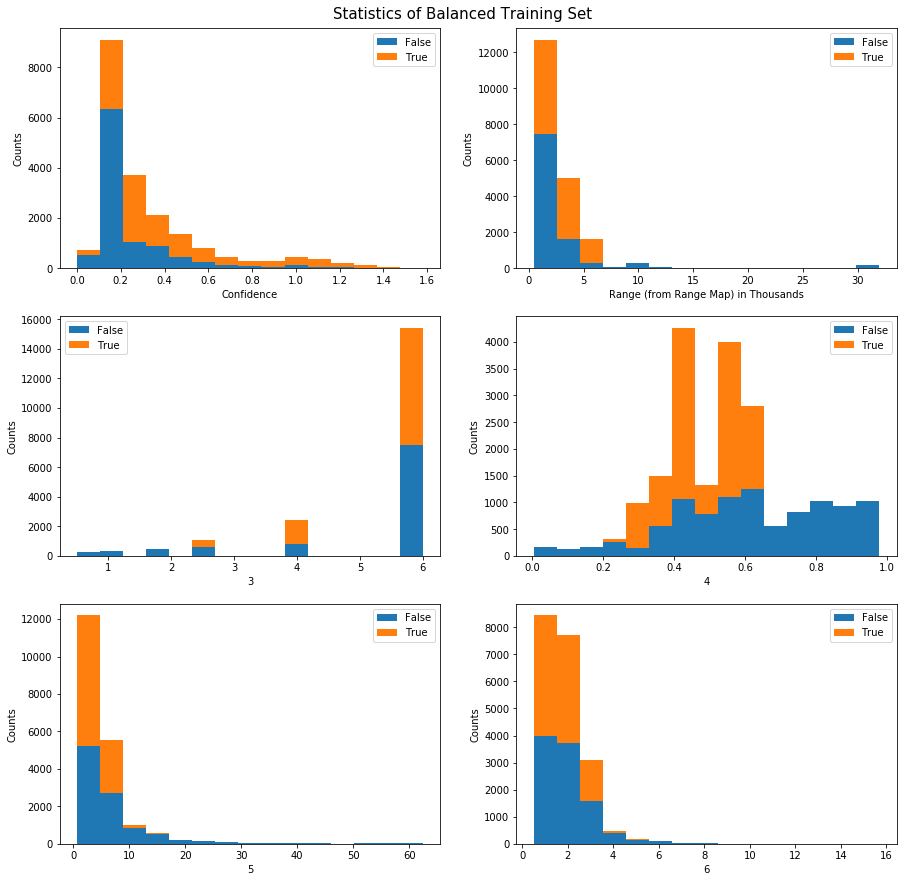

None

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
col_analysis=['labels', 'conf',
       'rangemap', 'range', 'y', 'wid', 'Hgt']
feature_EDA1(test_data)

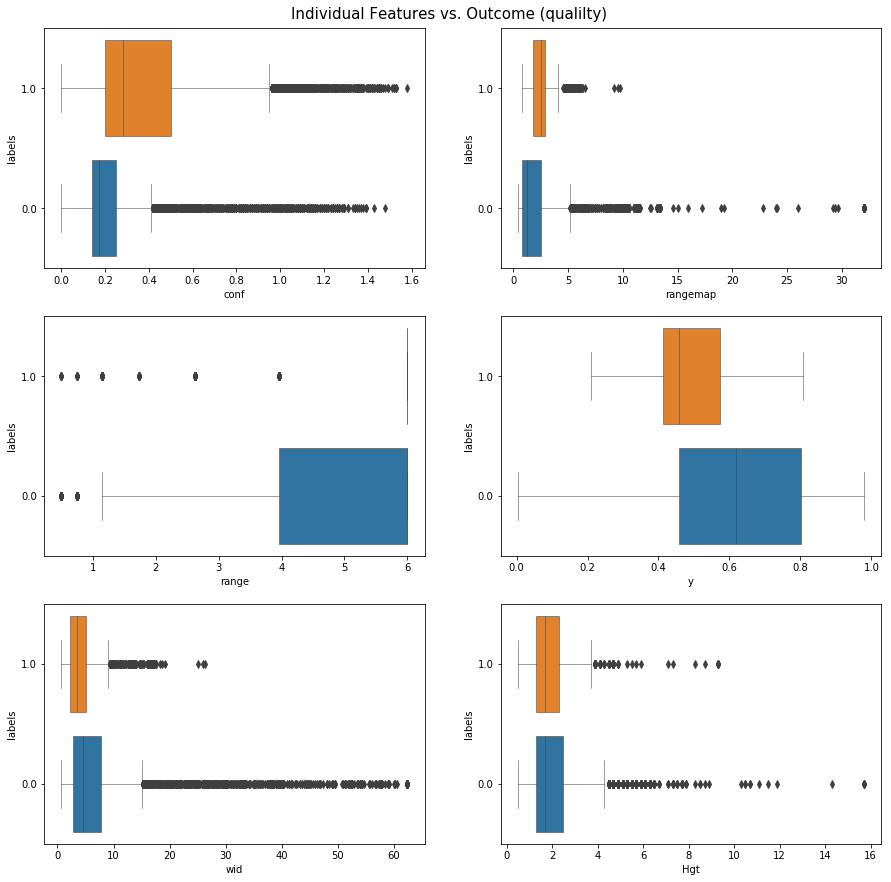

None

In [26]:
feature_EDA2(test_data)

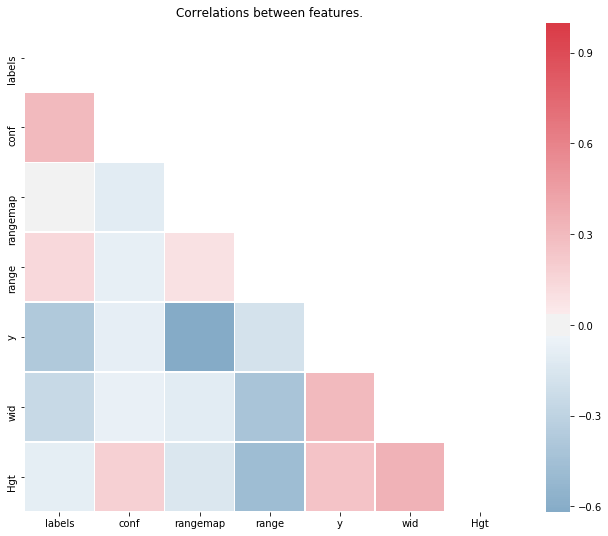

None

In [14]:
feature_EDA3(test_data)

(3, 2)


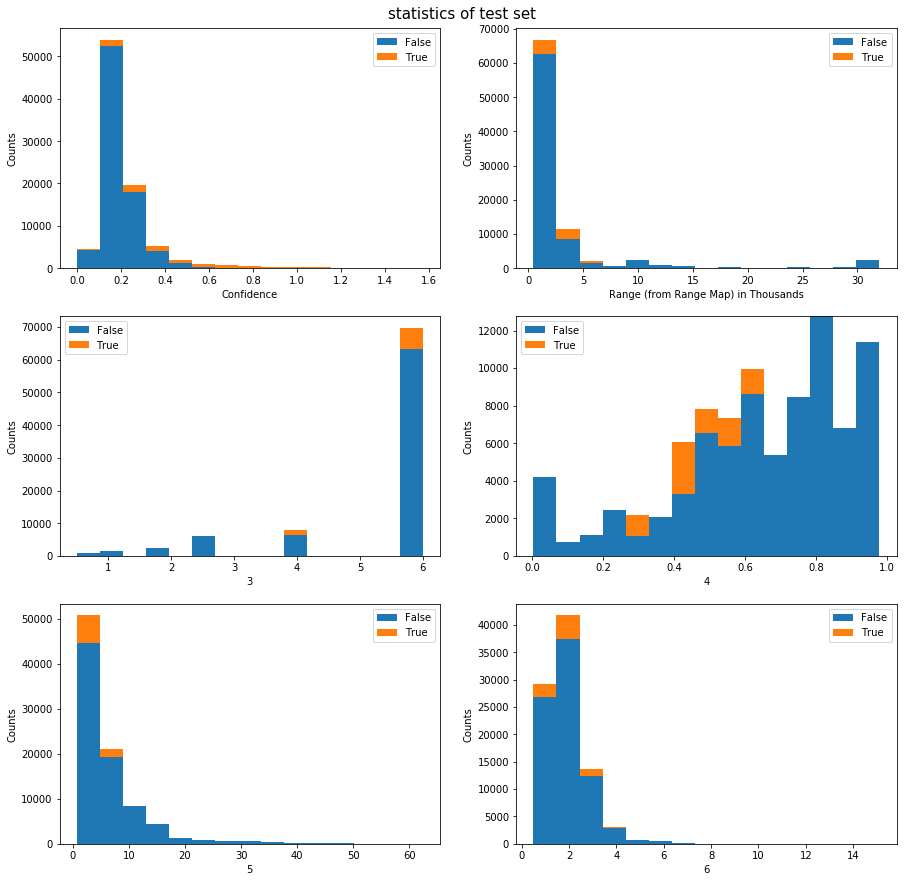

None

In [15]:
feature_EDA1(val_data)

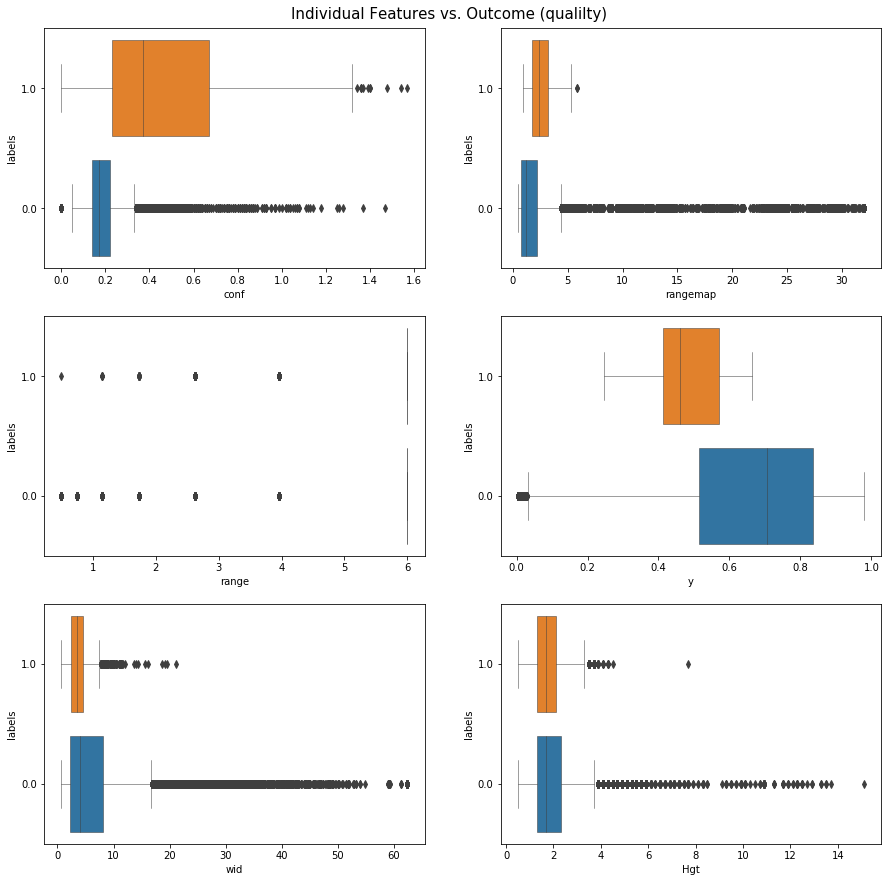

None

In [16]:
feature_EDA2(val_data)

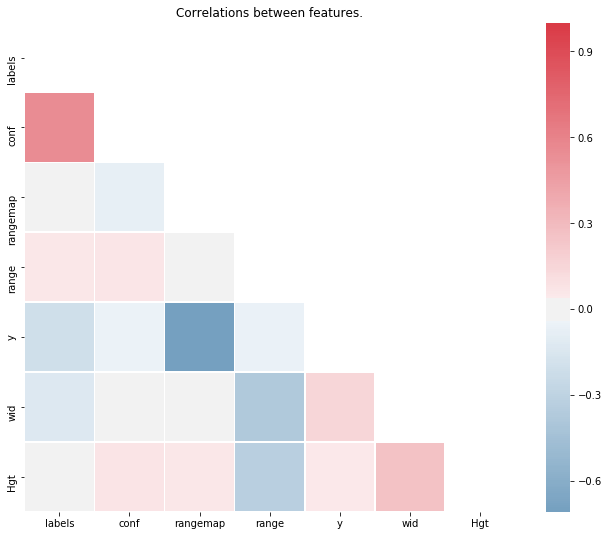

None

In [17]:
feature_EDA3(val_data)

In [18]:

#test_data=make_val_data(inputs)
#test_data = clean_up(test_data)
print(np.unique(test_data['labels'],return_counts=True))
generator = generate_X(test_data_norm,image_path=base_dir,batch_size=100,features =6,bounding_box_range=True,
                 y_position=True)
x,y=next(generator)
normalize = 0
inputs=0
val_inputs=0        
gen_analysis(x)
print(np.unique(y['output'], return_counts=True))
one = x,y
print(len(one))
print(type(one),type(one[0]), type(one[1]))
print([o.shape for k, o in one[0].items() ], one[1]['output'].shape)
print([o[1].dtype for k, o in one[0].items() ],type(one[1]['output'].dtype))

import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(np.array(x['input'][99][:,:,0], dtype='float64'))
plt.imshow(np.array(x['input'][99], dtype='float64'))

(array([False, True], dtype=object), array([10000, 10000]))


NameError: name 'test_data_norm' is not defined

In [37]:
loss_function='binary_crossentropy'
#optimizer=tf.keras.optimizers.Adagrad(lr=0.1, epsilon=1e-08, decay=0.0)
global_feature_classes=10
local_feature_classes=10
pool_height=4
pool_width=4
number_of_bounding_boxes_per_frame=1
number_roi_features=5
bounding_box_conf=True
bounding_box_range=True
rangemap_box_range=True
y_position=True
wid_included=True
hgt_icluded=True
time_cir=False
model_name = 'bal_1chan_val_gen_'+datetime.now().strftime("%m-%d-%H%M")
print(model_name)

bal_1chan_val_gen_03-05-1603


In [38]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0
model=None

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value

np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value

tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
#from tensorflow.keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)


img_input = tf.keras.layers.Input(shape=(512,640,3),name="input")
vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                                          input_shape=(512,640,3),pooling='max', include_top=False,input_tensor=img_input)
vgg_out = vgg16.get_layer('block5_conv3').output

roi_input=tf.keras.layers.Input(shape=(number_of_bounding_boxes_per_frame,number_roi_features,),
                                name='bounding_boxes', dtype='int32')

def roi( arr):
    from tensorflow.python.keras import backend
    from roi_pooling.roi_pooling_ops import roi_pooling
    img_input=arr[0]
    roi_input=arr[1]
    roi=roi_pooling(img_input, roi_input, pool_height=pool_height, pool_width=pool_width)
    #print(roi.shape)
    return roi# roi_pooling(img_input, roi_input, pool_height=4, pool_width=4)

roi_output = tf.keras.layers.Lambda(roi)((vgg_out, roi_input));

#local/object context

local_object_context = tf.keras.layers.Input(shape=(4*local_feature_classes,),name='local_object_context')

#global scene context
global_scene_context = tf.keras.layers.Input(shape=(global_feature_classes,),name='global_scene_context')


#range, confidence, time of day
feature_count=0
if bounding_box_range:
    feature_count+=1
if bounding_box_conf:
    feature_count+=1
if rangemap_box_range:
    feature_count+=1
if y_position:
    feature_count+=1
if wid_included:
    feature_count+=1
if hgt_icluded:
    feature_count+=1
if time_cir:
    feature_count+=1
range_confidence = tf.keras.layers.Input(shape=(feature_count*number_of_bounding_boxes_per_frame,),name='range_confidence')

#concatenate not equal to Concatenate
merge_one = tf.keras.layers.Concatenate(axis=1)([local_object_context, global_scene_context])
merge_two = tf.keras.layers.Concatenate(axis=1)([merge_one, range_confidence])
roi_out_flat  = tf.keras.layers.Flatten()(roi_output)



merge_three = tf.keras.layers.Concatenate(axis=1)([merge_two,roi_out_flat])
merge_three = tf.keras.layers.Dropout(0.2)(merge_three)
dense_0 = tf.keras.layers.Dense(1200, activation='relu')(merge_three)
dense_0 = tf.keras.layers.Dropout(0.2)(dense_0)
dense_1 = tf.keras.layers.Dense(500, activation='relu')(dense_0) #(merge_three)
dense_1 = tf.keras.layers.Dropout(0.2)(dense_1)
out = tf.keras.layers.Dense(1, activation='sigmoid' ,name="output")(dense_1)

model = tf.keras.models.Model(inputs=[local_object_context, global_scene_context, range_confidence,img_input,roi_input], outputs=out)


#epochs=50
#batch_size=2
#validation_split=0.2
class_weight = {0: 1., 1: 1.3 }


#optimizer = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
#model.compile(optimizer=optimizer, loss=loss_function, metrics=['acc',f1_m,precision_m, recall_m])

#labels=labels.reshape([labels.shape[0],1])
#inputs['bounding_boxes']=inputs['rois'].reshape([inputs['rois'].shape[0],1,5])
#val_labels=val_labels.reshape([val_labels.shape[0],1])
#val_inputs['bounding_boxes']=val_inputs['rois'].reshape([val_inputs['rois'].shape[0],1,5])

#inputs['range_confidence']= inputs['range_confidence'][:,0:6]


'''
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint(model_name+'.mdl_wts.hdf5', save_best_only=True, monitor='val_f1_m', mode='max', verbose=1)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_f1_m', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='max')

logdir = "logs/updated_images/" + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(x=inputs,y=labels,validation_split=validation_split,batch_size=batch_size,epochs=epochs,class_weight=class_weight,steps_per_epoch=None, callbacks=[earlyStopping, mcp_save, reduce_lr_loss,tensorboard_callback])
#history = model.fit(x=inputs,y=labels,validation_data=(val_inputs, val_labels),batch_size=batch_size,epochs=epochs,class_weight=class_weight,steps_per_epoch=None, callbacks=[earlyStopping, mcp_save, reduce_lr_loss,tensorboard_callback])
#'''
pass

In [57]:
"""json_model=base_dir+'models/bal_1_chan_val_xhw_3drop_controlled_data02-06-0755model.json'
json_model1=base_dir+'models/bal_1_chan_val_xhw_3drop_controlled_data02-06-0914model.json'
json_model2=base_dir+'models/bal_1_modelcheckin1234.json'
model1=base_dir+'bal_1chan_val_xhw_3d_gen.mdl_wts.hdf5'
model2=base_dir+'bal_1chan_val_xhw_2drop.mdl_wts.hdf5'
model3=base_dir+'bal_3chan_val_xhw_2drop_time01-27-2353.mdl_wts.hdf5'
model.load_weights(model2)
print("Loaded model from disk")"""

Loaded model from disk


In [37]:

#learning reate
learning_rate=0.0008

#learning scedule
#epochs
epochs=60
#steps per epoch

batch_size=8
steps_per_epoch=450
validation_steps=100

class_weight = {0: 1.,
                1: 1.3
               }

#gc.collect()
model_name = 'bal_1chan_val_xhw_3d_gen_tf2_4'
#model.summary()
#model=create_model()




#optimizer
#optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate, epsilon=1e-08, decay=0.0)
#optimizer=tf.keras.optimizers.Adam(lr=learning_rate, epsilon=1e-08, decay=0.0)
#optimizer = tf.keras.optimizers.Adadelta(lr=learning_rate, epsilon=1e-07, rho=0.95)
#optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
optimizer = tf.keras.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['acc',f1_m,precision_m, recall_m])





generator = generate_X(test_data_norm,image_path=base_dir,batch_size=batch_size*steps_per_epoch,features =6,bounding_box_range=True,
                 y_position=True)
val_generator = generate_X(val_data_norm,image_path=base_dir,batch_size=batch_size*validation_steps,features =6,bounding_box_range=True,
                 y_position=True)
val_x,val_y = next(val_generator)

lr_new = learning_rate
max_score = 0
stale_limit=2
global_stale_limit=9
slowdown = 0; global_slowdown=1
primary_metric = 'val_f1_m'
story=[]
for i in range(epochs):
    print('epoch: ',i)
    x=None; y=None


    
    
    x,y =next(generator)
    

    schedule_lr=tf.keras.callbacks.LearningRateScheduler(lambda x : lr_new, verbose=1)
    history = model.fit(x=x,y=y,batch_size=batch_size,validation_data=(val_x,val_y),
                                  epochs=1,#class_weight=class_weight, verbose=1, max_queue_size=10,
                                 callbacks=[schedule_lr] ) #validation_steps=validation_steps,
                                  #callbacks=[earlyStopping, mcp_save, schedule_lr,tensorboard_callback])
        
        
    story.append(history.history)
    slowdown+=1; global_slowdown+=1
    if history.history[primary_metric][0]+0.00002 > max_score:
        max_score=history.history[primary_metric]
        slowdown=0
        global_slowdown = 0
        model.save_weights(model_name+".h5")
        print("New top model")
    elif stale_limit <= slowdown :
        lr_new *= 0.6
        slowdown =0
    elif global_slowdown >global_stale_limit:
        print("stale score training ceased")
        break
#'''samples_per_epoch = batch_size * number_of_batches

Generate one batch of data
0 15980 19.0
batch # 1 batch_size 15980  800 19.0 800 (15980, 15)
epoch:  0
Generate one batch of data
0 20000 5.0
batch # 1 batch_size 20000  3600 5.0 3600 (20000, 15)
Train on 3600 samples, validate on 800 samples
Epoch 1/1

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0008.
3600/3600 [==============================] - 838s 233ms/step - loss: 0.6314 - acc: 0.7042 - f1_m: 0.7104 - precision_m: 0.6914 - recall_m: 0.7996 - val_loss: 0.4997 - val_acc: 0.8425 - val_f1_m: 0.8266 - val_precision_m: 0.8124 - val_recall_m: 0.8848
New top model
epoch:  1
Generate one batch of data
1 20000 5.0
batch # 2 batch_size 20000  3600 5.0 3600 (20000, 15)
Train on 3600 samples, validate on 800 samples
Epoch 1/1

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0008.
3600/3600 [==============================] - 834s 232ms/step - loss: 0.5594 - acc: 0.7425 - f1_m: 0.7047 - precision_m: 0.7250 - recall_m: 0.7442 - val_loss: 0.4272 - val_acc: 0.8638

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3600/3600 [==============================] - 826s 229ms/step - loss: 0.4268 - acc: 0.7961 - f1_m: 0.7807 - precision_m: 0.7581 - recall_m: 0.8490 - val_loss: 0.3041 - val_acc: 0.8700 - val_f1_m: 0.8512 - val_precision_m: 0.8459 - val_recall_m: 0.8928
epoch:  31
Generate one batch of data
1 20000 5.0
batch # 2 batch_size 20000  3600 5.0 3600 (20000, 15)
Train on 3600 samples, validate on 800 samples
Epoch 1/1

Epoch 00001: LearningRateScheduler reducing learning rate to 4.83729408e-06.
3600/3600 [==============================] - 836s 232ms/step - loss: 0.4263 - acc: 0.7881 - f1_m: 0.7679 - precision_m: 0.7471 - recall_m: 0.8323 - val_loss: 0.3041 - val_acc: 0.8688 - val_f1_m: 0.8498 - val_precision_m: 0.8434 - val_recall_m: 0.8928
epoch:  32
Generate one batch of data
2 20000 5.0
batch # 3 batch_size 20000  3600 5.0 3600 (20000, 15)
Train on 3600 samples, validate on 800 samples
Epoch 1/1

Epoch 00001: LearningRateScheduler reducing learning rate to 4.83729408e-06.
3600/3600 [=========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1208/3600 [=========>....................] - ETA: 8:28 - loss: 0.4407 - acc: 0.7889 - f1_m: 0.7814 - precision_m: 0.7591 - recall_m: 0.8446

KeyboardInterrupt: 

In [84]:
story

[{'acc': [0.7852777777777777],
  'f1_m': [0.743711463742786],
  'loss': [0.5577595409088665],
  'precision_m': [0.8205740692218145],
  'recall_m': [0.734669314192401],
  'val_acc': [0.82],
  'val_f1_m': [0.8196385473012924],
  'val_loss': [0.4384492576122284],
  'val_precision_m': [0.7969047635793686],
  'val_recall_m': [0.8850714281201363]},
 {'acc': [0.8202777777777778],
  'f1_m': [0.7949669890271293],
  'loss': [0.4134166263209449],
  'precision_m': [0.8329973552293247],
  'recall_m': [0.8006137577030393],
  'val_acc': [0.84125],
  'val_f1_m': [0.8363351303339005],
  'val_loss': [0.3883501272648573],
  'val_precision_m': [0.8364761900901795],
  'val_recall_m': [0.8750714281201363]},
 {'acc': [0.8130555555555555],
  'f1_m': [0.7908887922763824],
  'loss': [0.3906719981299506],
  'precision_m': [0.834722221924199],
  'recall_m': [0.7983042335510254],
  'val_acc': [0.84625],
  'val_f1_m': [0.8419492343068122],
  'val_loss': [0.3883584974706173],
  'val_precision_m': [0.8319047603011132

In [38]:
#latest
story

[{'acc': [0.7041666666666667],
  'f1_m': [0.710428447789616],
  'loss': [0.6313722261455323],
  'precision_m': [0.6913809558418063],
  'recall_m': [0.799624339805709],
  'val_acc': [0.8425],
  'val_f1_m': [0.8266482564806938],
  'val_loss': [0.49969676524400714],
  'val_precision_m': [0.8123571410775184],
  'val_recall_m': [0.8847976166009903]},
 {'acc': [0.7425],
  'f1_m': [0.7046686897012923],
  'loss': [0.5594045501947403],
  'precision_m': [0.7250476211971707],
  'recall_m': [0.7442380959457822],
  'val_acc': [0.86375],
  'val_f1_m': [0.8409016180038452],
  'val_loss': [0.42718838036060336],
  'val_precision_m': [0.8421190455555916],
  'val_recall_m': [0.8743809509277344]},
 {'acc': [0.7422222222222222],
  'f1_m': [0.738340487645732],
  'loss': [0.5337677951322661],
  'precision_m': [0.7204735507898861],
  'recall_m': [0.8018809551000595],
  'val_acc': [0.8575],
  'val_f1_m': [0.8384896418452263],
  'val_loss': [0.39053816989064216],
  'val_precision_m': [0.8202857154607773],
  'va

In [55]:

model.save_weights("pretrained_good_y_range_1chan_.h5")
print("Saved model to disk")

Saved model to disk


In [56]:
model.save_weights("pretrained_good_y_range_1chan_2.h5")

In [ ]:
#model_name='bal_3chan_val_xhw_2drop'
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5

 
# later...
history.history[primary_metric]

history.history

In [45]:
import sys
tmp=[]
for var, obj in locals().items():
    tmp.append(( sys.getsizeof(obj), var))
tmp.sort(key = lambda x: x[0])
print(tmp[-10:])

[(5944, '_i6'), (5948, '_i5'), (6552, '_i28'), (8928, '_i11'), (8928, '_i40'), (19440, '_i26'), (23464, '_i9'), (25444, '_i21'), (41000, '_i8'), (118121792, 'val_data')]


In [44]:
y_double_stack=0
verification_data=0
results1=0
results=0
y_stack=0
y_ESRtrue = 0
y_ESRpred = 0
test_data =0 
more_test_data = 0
more_val_data=0

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
verification_data = pd.read_pickle(base_dir+'data/frame_1_validation_py2_pds.pkl')
print_features(verification_data)
print(len(verification_data['filename']))
print(len(np.unique(verification_data['filename'])))
#print(len(more_test_data['filename']))
#print(len(np.unique(more_test_data['filename'])))
#print(np.unique(more_test_data['filename']))
np.unique(len(verification_data['filename']))

min and max   conf (0.51, 0.0)  rangemap (3.578, 0.528)  range (5.999, 0.756)  y (0.978515625, 0.40625)  wid (62.4, 0.7)  Hgt (10.9, 0.5)
total length of validation data 5400
5400
6


array([5400])

(3, 2)


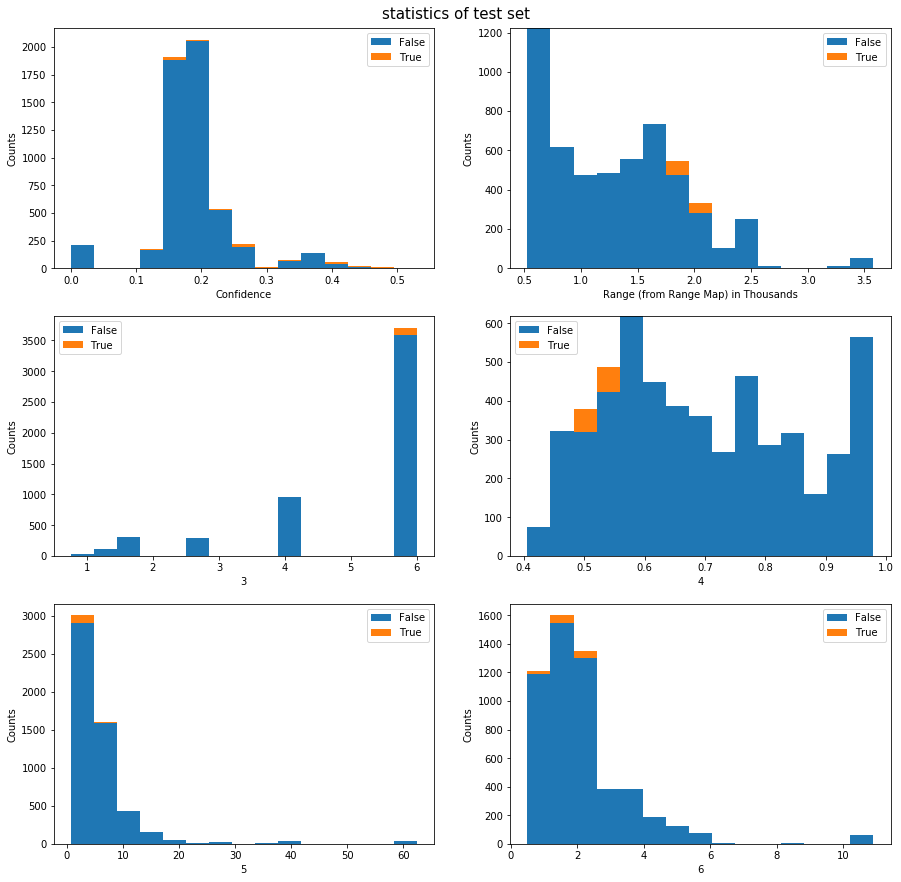

None

In [17]:

col_analysis=['labels', 'conf',
       'rangemap', 'range', 'y', 'wid', 'Hgt']
feature_EDA1(verification_data,subscript="_verification")

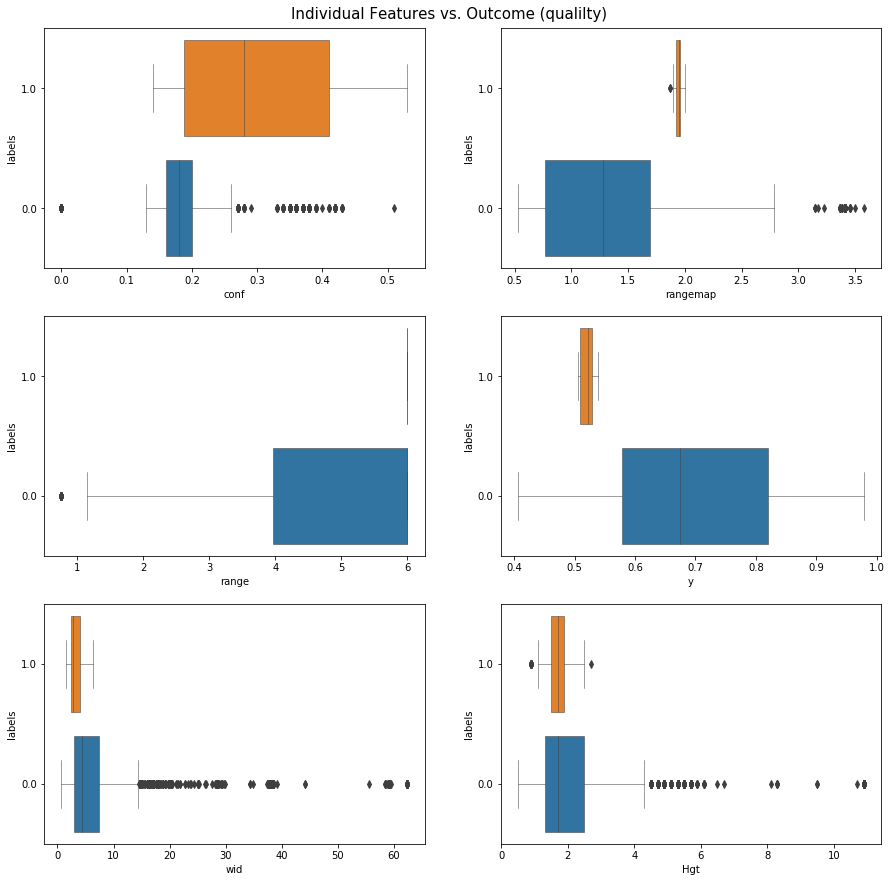

None

In [17]:
feature_EDA2(verification_data,subscript="_verification")

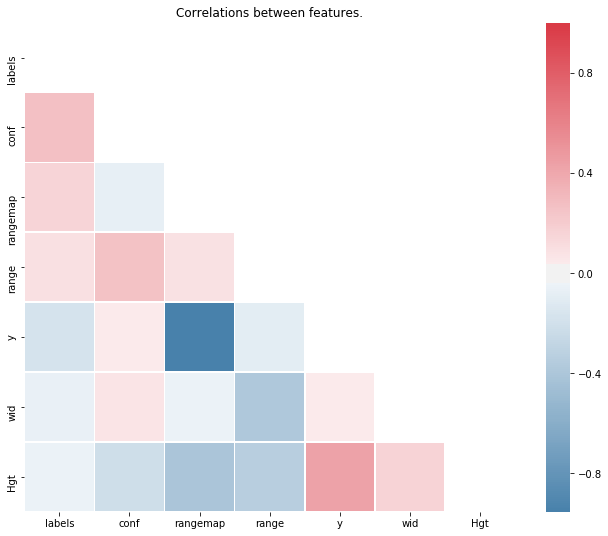

None

In [18]:
feature_EDA3(verification_data,subscript="_verification")

In [ ]:
#verification_data_norm =  normalize(gauss_normalize,stats,column_names,verification_data.copy())

In [20]:
stats ={'conf': [0.1818904590098017, 0.1181622865211339], 'rangemap': [2.7273172128683116, 4.709290451829926], 'range': [5.11838980756068, 1.6430380213772784], 'y': [0.6251205288353127, 0.22616891888414536], 'wid': [7.147089597113857, 8.12325808978054], 'Hgt': [1.986997394267456, 1.1321398953002695]}
#test data balanced avco11 all
def generate_X(list_IDs,batch_size=32,image_path=base_dir,features=4,channels=3,
               bounding_box_conf=True,bounding_box_range=False, rangemap_box_range=True, stats={},
                 y_position=False,wid_included=True,hgt_icluded=True,time_of_day=False, dim=(512,640)):
        'Generates data containing batch_size images'
        # Initialization
        channel=3
        len_epoch = np.floor(len(list_IDs) // batch_size) #'Denotes the number of batches per epoch'
        
        print("length of an epoch",len_epoch)
        indexes = np.arange(len(list_IDs))
        print(indexes.shape,indexes.dtype)
        np.random.shuffle(indexes)
        index=0    
        def _load_grayscale_image(image_path,chan = False, cv2_true = False, box=[], dim=dim):
            'Load grayscale image'

            if chan:
                image_preprocess = vgg1_preprocess_input(seg_img, rangemap,image_path, order='bw')
            elif cv2_true:
                'Load grayscale image'
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255
                image_preprocess = np.stack([img,img,img], axis=2)#.reshape(512,640,3)
            else:
                # convert the image pixels to a numpy array
                image_load = tf.keras.preprocessing.image.load_img(image_path, target_size=(dim[0],dim[1]))
                # convert the image pixels to a numpy array
                image_2_arr = tf.keras.preprocessing.image.img_to_array(image_load)
                # prepare the image for the VGG model
                image_preprocess = tf.keras.applications.vgg16.preprocess_input(image_2_arr)
            if box!=[]:
                min_pix, max_pix = [0,1]#[-123.68000030517578, 151.06100463867188]
                image_preprocess[:,:,0] = create_mask(min_pix, max_pix, box, dim)
                
            return  image_preprocess
        def normalize_batch(ID,stats,feature):
            stat=stats[feature]
            return (ID[feature]-stat[0])/float(stat[1])
            
        while True:
            print('Generate one batch of data')
            print(index,len(indexes),len_epoch)
            # Generate indexes of the batch
            index+=1
            if index>= len_epoch:
                index=0
                np.random.shuffle(indexes)
            indexes_temp = indexes[index*batch_size: (index+1)*batch_size]
            print(index,len(indexes),len_epoch,batch_size,list_IDs.shape)
            # Find list of IDs
            list_IDs_temp = [list_IDs.iloc[k] for k in indexes_temp]
            print(index,len(indexes),len(list_IDs_temp),len_epoch,batch_size,list_IDs.shape)
            #generate data arrays
            local_object_features= np.empty((batch_size, 40),dtype='float32')
            globalFeatures = np.empty((batch_size, 10),dtype='float32')
            range_confidence = np.empty((batch_size, features),dtype='float32')
            original_feature = np.empty((batch_size, 6),dtype='float32')
            bounding_boxes = np.empty((batch_size, 5),dtype='float32')
            image = np.empty((batch_size, 512, 640, channels),dtype='float32')     
            labels = np.empty((batch_size, 1), dtype=int)
            filenames =[]
            framenumbers =  []
            '''
            ['filename','framenumber','boundboxIndex','bbox#',"labels",'conf','rangemap','range','y','range_confidence',
                   'wid','Hgt','bounding_boxes', 'local_object_context', 'global_scene_context']
            '''
            # Generate data
            for i, ID in enumerate(list_IDs_temp):
                #frnm = ID['framenums']
                #bboxes=ID['bboxes']
                #name = ID['filenames']
                labels[i,] = 1 if ID['labels'] else 0
                local_object_features[i,] = np.array(ID['local_object_context'],dtype='float32').copy()
                globalFeatures[i,] = np.array(ID[ 'global_scene_context'],dtype='float32').copy()
                hand_features=[]
                if bounding_box_conf:
                    hand_features.append(normalize_batch(ID,stats,'conf'))
                if bounding_box_range:
                     hand_features.append(normalize_batch(ID,stats,'range'))
                if rangemap_box_range:
                    hand_features.append(normalize_batch(ID,stats,'rangemap'))
                if y_position:
                    hand_features.append(normalize_batch(ID,stats,'y'))
                if wid_included:
                     hand_features.append(normalize_batch(ID,stats,'wid'))
                if hgt_icluded:
                     hand_features.append(normalize_batch(ID,stats,'Hgt'))
                if time_of_day:
                     hand_features.append(normalize_batch(ID,stats,'time'))
                range_confidence[i,] = np.array(hand_features,dtype='float32').copy()
                original_feature[i,] = np.array(ID['range_confidence']).copy()
                bounding_boxes[i,] = get_bounding_box(ID['bounding_boxes'],1,dim)
                filenames.append(ID['filename'])
                framenumbers.append(ID['framenumber'])
                # Store sample
                image[i,] = _load_grayscale_image(get_avi_dir(ID['filename'], ID['framenumber'], image_path),
                                                 cv2_true = True,)#box = ID['bounding_boxes'])


            #return X
            inpts={}
            inpts['filename']=np.array(filenames).reshape(-1,1)
            inpts['framenumber']=np.array(framenumbers).reshape(-1,1)
            inpts['local_object_context']=local_object_features
            inpts['global_scene_context']=globalFeatures
            inpts['range_confidence']=range_confidence
            inpts['input']=image
            inpts['original_features']= original_feature
            inpts['bounding_boxes']=bounding_boxes.reshape((batch_size,1,5))
            
            yield inpts, {'output': labels.reshape((batch_size,1))}

0    0.43
Name: conf, dtype: object
length of an epoch 54.0
(5400,) int64
Generate one batch of data
0 5400 54.0
1 5400 54.0 100 (5400, 15)
1 5400 100 54.0 100 (5400, 15)
range_confidence
-3.0494415760040283 9.61962604522705
global_scene_context
0.0 0.8479911684989929
local_object_context
0.0 1.0
bounding_boxes
1.0 631.0
input
0.239215686917305 1.0
[0 1]


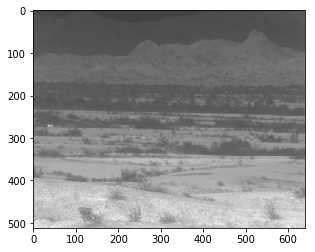

In [32]:
#verification_data = val_data
print(verification_data['conf'].head(1))
generator = generate_X(verification_data,image_path=base_dir,batch_size=100,features =6,bounding_box_range=True,
                 y_position=True,stats=stats)
x,y=next(generator)
gen_analysis(x)
#gen_analysis_1(x)
print(np.unique(y['output']))
plt.imshow(x['input'][0])

In [42]:
print(val_data.columns)
print(np.unique(val_data['labels'], return_counts=True))
fnames = np.unique(val_data['filename'], return_counts=True)
print(fnames)
print(fnames[0][np.argwhere(fnames[1]==60)][0])
print(np.unique(val_data['framenumber'], return_counts=True))

Index([u'filename', u'framenumber', u'boundboxIndex', u'bbox#', u'labels',
       u'conf', u'rangemap', u'range', u'y', u'wid', u'Hgt',
       u'range_confidence', u'bounding_boxes', u'local_object_context',
       u'global_scene_context'],
      dtype='object')
(array([False, True], dtype=object), array([80750,  7990]))
(array([u'avco10122_1001', u'avco10122_1002', u'avco10122_1003',
       u'avco10122_1004', u'avco10122_1005', u'avco10122_1006',
       u'avco10122_1007', u'avco10122_1008', u'avco10122_1009',
       u'avco10122_1010', u'avco10122_1011', u'avco10122_1012',
       u'avco10122_1013', u'avco10122_1014', u'avco10122_1015',
       u'avco10122_1016', u'avco10122_1017', u'avco10122_1018',
       u'avco10122_1019', u'avco10122_1020', u'avco10122_1021',
       u'avco10122_1022', u'avco10122_1023', u'avco10122_1024',
       u'avco10122_1025', u'avco10122_1026', u'avco10122_1027',
       u'avco10122_1028', u'avco10122_1029', u'avco10122_1030',
       u'avco10122_1031', u'avco1012

(array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 210,
       240, 250, 270, 300, 350, 360, 400, 450, 500, 540, 720, 900, 1080,
       1260, 1440, 1620, 1800], dtype=object), array([5130, 5130, 5310, 5130, 5550, 5310, 5130, 5130, 5310, 5550,  180,
        600, 3360,  420,  180,  180,  420,  180,  600,  420, 3180,  420,
        420,  420, 3150, 3150, 3150, 3150, 3120, 3120, 3120, 3120]))


In [43]:

val_data = val_data[val_data.filename != 'avco10325_1022']
print(np.unique(val_data['labels'], return_counts=True))
fnames = np.unique(val_data['filename'], return_counts=True)
print(fnames)
print(np.unique(val_data['framenumber'], return_counts=True))

(array([False, True], dtype=object), array([80699,  7981]))
(array([u'avco10122_1001', u'avco10122_1002', u'avco10122_1003',
       u'avco10122_1004', u'avco10122_1005', u'avco10122_1006',
       u'avco10122_1007', u'avco10122_1008', u'avco10122_1009',
       u'avco10122_1010', u'avco10122_1011', u'avco10122_1012',
       u'avco10122_1013', u'avco10122_1014', u'avco10122_1015',
       u'avco10122_1016', u'avco10122_1017', u'avco10122_1018',
       u'avco10122_1019', u'avco10122_1020', u'avco10122_1021',
       u'avco10122_1022', u'avco10122_1023', u'avco10122_1024',
       u'avco10122_1025', u'avco10122_1026', u'avco10122_1027',
       u'avco10122_1028', u'avco10122_1029', u'avco10122_1030',
       u'avco10122_1031', u'avco10122_1032', u'avco10122_1033',
       u'avco10122_1034', u'avco10122_1035', u'avco10122_1036',
       u'avco10122_1037', u'avco10122_1038', u'avco10122_1039',
       u'avco10122_1040', u'avco10122_1041', u'avco10122_1042',
       u'avco10122_1043', u'avco10125_1001'

In [23]:
80699+  7981

88680

In [39]:
model.load_weights('official_eval/gold_1chan_val_xhw_3d_gen_tf2_4.h5')

In [40]:
verification_data_norm=None
stats ={'conf': [0.1818904590098017, 0.1181622865211339], 'rangemap': [2.7273172128683116, 4.709290451829926], 'range': [5.11838980756068, 1.6430380213772784], 'y': [0.6251205288353127, 0.22616891888414536], 'wid': [7.147089597113857, 8.12325808978054], 'Hgt': [1.986997394267456, 1.1321398953002695]}
#test data balanced avco11 all
#model=0; verification_data=0
number_batches=6
def generate_predictions(model=model,verification_data=verification_data,
                         base_dir=base_dir,number_batches=number_batches,stats=stats ):
    data_len=len(verification_data['labels'])

    print('actual data length',data_len)
    generator = generate_X(verification_data,image_path=base_dir,batch_size=data_len//number_batches,features =6,
                           bounding_box_range=True, y_position=True,stats=stats)
    
   
    y_ESRpred=[];
    y_ESRtrue=[];
    x_values=[];x_filenames=[];x_framenumbers=[];x_bounding_box=[]
    for i in range(number_batches):

        x,y=next(generator)
   
        predictions_val=model.predict(x=x, verbose=1)



        y_ESRpred.extend(predictions_val)
        y_ESRtrue.extend(y['output'])
        x_values.extend(x['original_features'])
        x_filenames.extend(x['filename'])
        x_framenumbers.extend(x['framenumber'])
        x_bounding_box.extend(x['bounding_boxes'])
        #print(len(y_ESRpred),len( y_ESRtrue),len(x_values)
    print("done")    
    y_ESRpred=np.array(y_ESRpred)
    y_ESRtrue=np.array(y_ESRtrue)
    y_stack=np.hstack((y_ESRtrue,y_ESRpred))
    print(y_stack[0])
    x_values = np.array(x_values)
    print(x_values.shape,y_stack.shape)
    y_double_stack=np.hstack((y_stack,x_values))
    y_double_stack=np.hstack((y_double_stack,x_filenames))
    y_double_stack=np.hstack((y_double_stack,x_framenumbers))
    y_double_stack=np.hstack((y_double_stack,np.array(x_bounding_box).reshape(-1,5)))
    print(y_double_stack.shape)
    np.save('predictions_good2.npy',y_double_stack)
    return y_double_stack

In [42]:
y_double_stack = generate_predictions(verification_data=verification_data,number_batches=1)

actual data length 5400
length of an epoch 1.0
(5400,) int64
Generate one batch of data
0 5400 1.0
0 5400 1.0 5400 (5400, 15)
0 5400 5400 1.0 5400 (5400, 15)
5400/5400 [==============================] - 362s 67ms/step
done
[0.00 0.01]
(5400, 6) (5400, 2)
(5400, 15)


(5400, 15)
fpr =  [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.01
 0.01 0.01 0.03 0.03 0.04 0.05 0.05 0.05 0.05 0.05 0.05 0.07 0.08 0.12
 0.16 0.18 0.24 0.34 0.45 0.57 0.71 0.85 0.93 0.95 0.96 1.00]
[0.00 0.02 0.02 0.03 0.06 0.06 0.08 0.09 0.11 0.15 0.19 0.22 0.27 0.31
 0.33 0.35 0.38 0.38 0.41 0.41 0.42 0.43 0.47 0.54 0.60 0.66 0.68 0.71
 0.71 0.72 0.73 0.74 0.75 0.81 0.94 0.98 0.99 1.00 1.00 1.00]
[1.53 0.53 0.51 0.50 0.49 0.48 0.47 0.46 0.45 0.44 0.43 0.42 0.41 0.40
 0.39 0.38 0.37 0.36 0.35 0.34 0.33 0.30 0.29 0.28 0.27 0.26 0.25 0.24
 0.23 0.22 0.21 0.20 0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.00]
esr fpr =  [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.02 0.03
 0.03 0.03 0.04 0.04 0.05 0.05 0.05 0.06 0.07 0.07 0.08 0.10 0.11 0.12
 0.13 0.14 0.14 0.15 0.16 0.16 0.17 0.18 0.19 0.20 0.21 0.22 0.23 0.24
 0.24 0.25 0.26 0.28 0.29 0.30 0.31 0.32 0.33 0.34 0.34 0.36 0.36 0.37
 0.38 0.38 0.39 0.40 0.41 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.47 0.48
 0.4

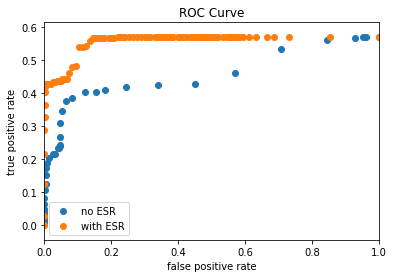

In [46]:


import sklearn.metrics as metrics

def get_any_results(arr, feature='conf'):

    results = pd.DataFrame(data=arr,  columns=['label','pred_val','conf','rangemap','range','y',
                   'wid','Hgt','filename','framenumber','nums','x1','y1','x2','y2']) 
    cols = ['label','pred_val','conf','rangemap','range','y',
                   'wid','Hgt','framenumber','x1','y1','x2','y2']
    results[cols] = results[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    return results
def best_results(results, lvl, feature='conf'):
    stat_counts = {"TN":[0,0],"FP":[0,1],"TP":[1,1],"FN":[1,0],}
    def digi(x):return 1 if x>lvl else 0
    def f(prediction,label,val=[0,0]):
            return 1 if prediction==val[1] and label==val[0] else 0
    results['prediction'] = results['pred_val'].map(digi)
    for key, val in stat_counts.items():
        results[key] = results[['prediction','label']].apply(lambda x: f(*x,val=val), axis=1)
        #holder = results[1 if (results['predictions']==val[0]) & (results['label']==val[1]) else 0]
        #results[key]=holder
    return results
def bayesian_criterion(results):
    y_true = results['label'].to_numpy()
    y_conf = results['conf'].to_numpy()
    y_pred = results['pred_val'].to_numpy()
    #calculate ROC
    fpr, tpr, thresh = metrics.roc_curve(y_true,y_conf)
    print('fpr = ',fpr)
    print( tpr)
    print(thresh)
    esr_fpr, esr_tpr, esr_thresh = metrics.roc_curve(y_true, np.around(y_pred,decimals=2))
    print('esr fpr = ',esr_fpr)
    print(esr_tpr)
    print( esr_thresh)
    print("Baseline results")
    def get_cutoff(true_counts, tpr, fpr,thresh):
        bc=[]
        for i in range(len(fpr)):
            criterion = tpr[i]*true_counts[1]
            criterion -= fpr[i]*true_counts[0]
            bc.append([criterion,thresh[i],tpr[i],fpr[i],tpr[i]*true_counts[1],fpr[i]*true_counts[0]])
        return max(bc, key=lambda x:x[0])
    true_counts = np.unique(results['label'],return_counts=True)[1]
    lvl = get_cutoff(true_counts, tpr, fpr,thresh)
    print(lvl)
    y_conf_pred = [1 if conf > lvl[1] else 0 for conf in y_conf]
    print(sum(y_conf_pred))
    print( 'false positive', true_counts[0],'true positive',true_counts[1])
    
    lvl = get_cutoff(true_counts, esr_tpr, esr_fpr,esr_thresh)
    print(lvl)
    y_predictions=[1 if conf > lvl[1] else 0 for conf in y_pred]
    print(sum(y_predictions))

    print(metrics.classification_report(y_true,y_conf_pred))
    print('ESR results')
    print(metrics.classification_report(y_true, y_predictions))
    fig, ax = plt.subplots()
    #ax.scatter( thresh,fpr)
    #ax.scatter( thresh,tpr)
    ax.scatter( fpr,tpr*.57, label="no ESR")
    ax.scatter( esr_fpr,esr_tpr*.57, label="with ESR")
    #ax.scatter( tpr,fpr)
    ax.set_xlim([0, 1])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.legend()
    plt.title('ROC Curve')
    plt.savefig("ROC.jpg", format='jpg')
    return best_results(results, lvl[1])
#print(y_double_stack.shape)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
results = get_any_results(y_double_stack)
print(results.shape)
print
results = bayesian_criterion(results)
#best_results(get_any_results(y_double_stack), lvl[1])
#[cutoff,thresh[i],tpr[i],fpr[i],tpr[i]*true_counts[1],fpr[i]*false_counts[0]])

Baseline results
15
false positive 5276 true positive 124
102
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5276
         1.0       0.93      0.11      0.20       124

   micro avg       0.98      0.98      0.98      5400
   macro avg       0.96      0.56      0.60      5400
weighted avg       0.98      0.98      0.97      5400

ESR results
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5276
         1.0       0.88      0.73      0.80       124

   micro avg       0.99      0.99      0.99      5400
   macro avg       0.94      0.86      0.90      5400
weighted avg       0.99      0.99      0.99      5400

(2, 2)


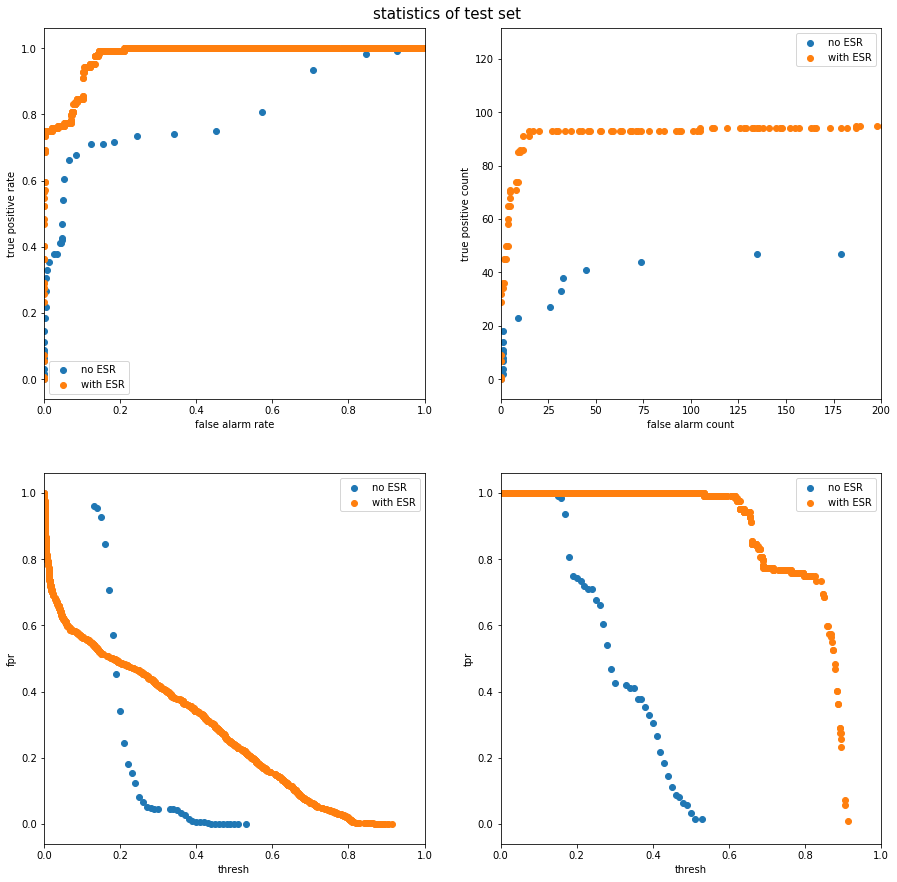

None

In [61]:
def real_ROC(results):
    y_true = results['label'].to_numpy()
    y_conf = results['conf'].to_numpy()
    y_pred = results['pred_val'].to_numpy()
    #calculate ROC
    fpr, tpr, thresh = metrics.roc_curve(y_true,y_conf)
    #print('fpr = ',fpr)
    #print( tpr)
    #print(thresh)
    esr_fpr, esr_tpr, esr_thresh = metrics.roc_curve(y_true, y_pred)
    #print('esr fpr = ',esr_fpr)
    #print(esr_tpr)
    #print( esr_thresh)
    print("Baseline results")
    def get_cutoff(true_counts, tpr, fpr,thresh):
        bc=[]
        for i in range(len(fpr)):
            criterion = tpr[i]*true_counts[1]
            criterion -= fpr[i]*true_counts[0]
            bc.append([criterion,thresh[i],tpr[i],fpr[i],tpr[i]*true_counts[1],fpr[i]*true_counts[0]])
        return max(bc, key=lambda x:x[0])
    true_counts = np.unique(results['label'],return_counts=True)[1]
    lvl = get_cutoff(true_counts, tpr, fpr,thresh)
    #print(lvl)
    y_conf_pred = [1 if conf > lvl[1] else 0 for conf in y_conf]
    print(sum(y_conf_pred))
    print( 'false positive', true_counts[0],'true positive',true_counts[1])
    
    lvl = get_cutoff(true_counts, esr_tpr, esr_fpr,esr_thresh)
    #print(lvl)
    y_predictions=[1 if conf > lvl[1] else 0 for conf in y_pred]
    print(sum(y_predictions))

    print(metrics.classification_report(y_true,y_conf_pred))
    print('ESR results')
    print(metrics.classification_report(y_true, y_predictions))
    fig, ax_grid = plt.subplots(2,2, figsize=(15,15))
    print(ax_grid.shape)
    #y = sample_df['labels'].astype(float)
    y_label = ['true positive rate', 'true positive count', 'fpr','tpr','5','6']
    x_label = ['false alarm rate', 'false alarm count', 'thresh','thresh','5','6']
    plots1=[( fpr,tpr, ),
            ( fpr*true_counts[0],tpr*true_counts[1]),
            ( thresh,fpr),
            ( thresh,tpr)]
    plots2=[( esr_fpr,esr_tpr, ),
            ( esr_fpr*true_counts[0],esr_tpr*true_counts[1]),
            ( esr_thresh,esr_fpr),
            ( esr_thresh,esr_tpr,)]
    lims=[1,200,1,1]
    for idx in range(4):
        ax=ax_grid[idx//2][idx%2]
        ax.scatter(*plots1[idx],label="no ESR")
        ax.scatter( *plots2[idx],label="with ESR")
        ax.set_xlabel(x_label[idx])
        ax.set_ylabel(y_label[idx])
        ax.set_xlim([0, lims[idx]])
        ax.legend()
        #ax_grid[idx//2][idx%3].hist(x, y, orient='h', linewidth=.5)
        #ax_grid[idx//2][idx%2].invert_yaxis()
    fig.suptitle("statistics of test set ", fontsize=15, y=0.9)
    subscript ="run1"
    plt.savefig("roc1"+subscript+".jpg", format='jpg')
    display(plt.show())
    
    
    #return best_results(results, lvl[1])
real_ROC(get_any_results(y_double_stack))
j=0

In [86]:
np.unique(results[[ 'filename', 'framenumber']],return_counts=True)

(array([1.0, 11.0, 21.0, 31.0, 41.0, 51.0, 61.0, 71.0, 81.0, 91.0, 101.0,
        111.0, 121.0, 131.0, 141.0, 151.0, 161.0, 171.0, 181.0, 191.0,
        201.0, 211.0, 221.0, 231.0, 241.0, 251.0, 261.0, 271.0, 281.0,
        291.0, u'avco12221_0001', u'avco13221_1001', u'avco13221_1002',
        u'avco13221_2001', u'avco13221_2002', u'avco13221_3001'],
       dtype=object),
 array([180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 900, 900, 900, 900, 900, 900]))

In [71]:
factors=['conf','rangemap','range','y','wid','hgt','time','pred_val']
def analyze_factor_panda(results,factor,factors=factors,bins=10,x=[1,10,6,1,20,10,1,1]):
    name=factor
    
    stat_counts = {"ff":[0,0],"ft":[0,1],"ff":[1,1],"tf":[1,0],}
    stat_counts = {"TN":[0,0],"FP":[0,1],"TP":[1,1],"FN":[1,0],}
    conf_ = {key:results.loc[results[key]==1,[factor]].to_numpy() for key,value in stat_counts.items()}
    

    
    
    factor=factors.index(factor)

    print(' TP ',len(conf_['TP']),' FN ',len(conf_['FN']),' TN ',len(conf_['TN']),' FP ',len(conf_['FP']))
    
    x=x[factor]
    hist = {key:np.histogram(value,bins=bins,range=(0,x)) for key, value in conf_.items()}
    #shist ={key:sum(val[0]) for key,val in hist.items()}
    print( name + "True Positive Recall "  , np.divide(hist["TP"],np.add(np.add(hist["TP"],hist['FN']),0.0000001))[0])
    print( name + "False Positive Recall "  , np.divide(hist["TN"],np.add(np.add(hist["TN"],hist['FP']),0.0000001))[0])
    #print( name + "Precision"  ,hist["TP"]/(hist["TP"]+hist['FP']+0.0000001))
    #print( name + "Accuracy"  ,(hist["TP"]+hist['TN'])/(hist["TP"]+hist['TN']+hist['FP']+hist['FN'])+0.0000001)
    #print(name + "False Positive" ,hist['FP']/(hist['FP']+hist['TN']+0.0000001))
    #print(name + "Miss Rate" ,hist['FN']/(hist['FN']+hist['TN']+0.0000001))
    
    factors=['Confidence','range from map in thousands ','predicted range in thousands','y %','wid','hgt','time %','ESR Confidence level']
    Other_factors=['Confidence level','Range (from Range Map) in Thousands ',
                   'Predicted Range','Y %','Bounding Box Width','Bounding Box Height','time %','ESR Confidence level']
    name =factors[factor]
    '''print( " Recall"  ,shist["TP"]/(shist["TP"]+shist['FN']+0.0000001))
    print("Precision"  ,shist["TP"]/(shist["TP"]+shist['FP']+0.0000001))
    print("Accuracy"  ,(shist["TP"]+shist['TN'])/(sum(list(shist.values()))+0.0000001))
    print("False Positive" ,shist['FP']/(shist['FP']+shist['TN']+0.0000001))
    print("Miss Rate" ,shist['FN']/(shist['FN']+shist['TN']+0.0000001))'''
    
    plt.figure(1,figsize=(20,10))
    plt.subplot(121)
    
    plt.hist([conf_['TN'],conf_['FP']],label = ["predicted False","predicted True"], stacked=True,bins=bins,range=(0,x))
    plt.title('Statistics for False Positive')
    plt.legend()
    plt.xlabel(factors[factor])
    plt.ylabel('Counts')
    #plt.show()
    #print(len(conf_ff),len(conf_ft))
    plt.savefig(name+"FalsePositivedataset_val.jpg", format='jpg')

    #plt.figure()
    plt.subplot(122)
    plt.hist([conf_["TP"],conf_['FN']],label = ["predicted True","predicted False"], stacked=True,bins=bins,range=(0,x))
    plt.title('Statistics for True Positive ')
    plt.xlabel(factors[factor])
    plt.ylabel('Counts')
    plt.legend(    )
    #plt.show()
    plt.savefig(name+"_TruePositivesdataset_val.jpg", format='jpg')
    
    '''plt.subplot(223)
    plt.hist([conf_["TP"],conf_['FP']],label = ["True Target","Not a Target"], stacked=True,bins=bins,range=(0,x))
    plt.title(Other_factors[factor]+" for True Positives\n balanced 1 channel dataset")
    plt.xlabel(factors[factor])
    plt.ylabel('Counts')
    plt.legend(    )
    plt.savefig(name+"_PredictedTruePositivesdataset_val.jpg", format='jpg')'''

 TP  91  FN  33  TN  5264  FP  12
pred_valTrue Positive Recall  [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.75 1.00 1.00 0.00]
pred_valFalse Positive Recall  [1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
 1.00 1.00 0.96 0.00 0.00 0.00]


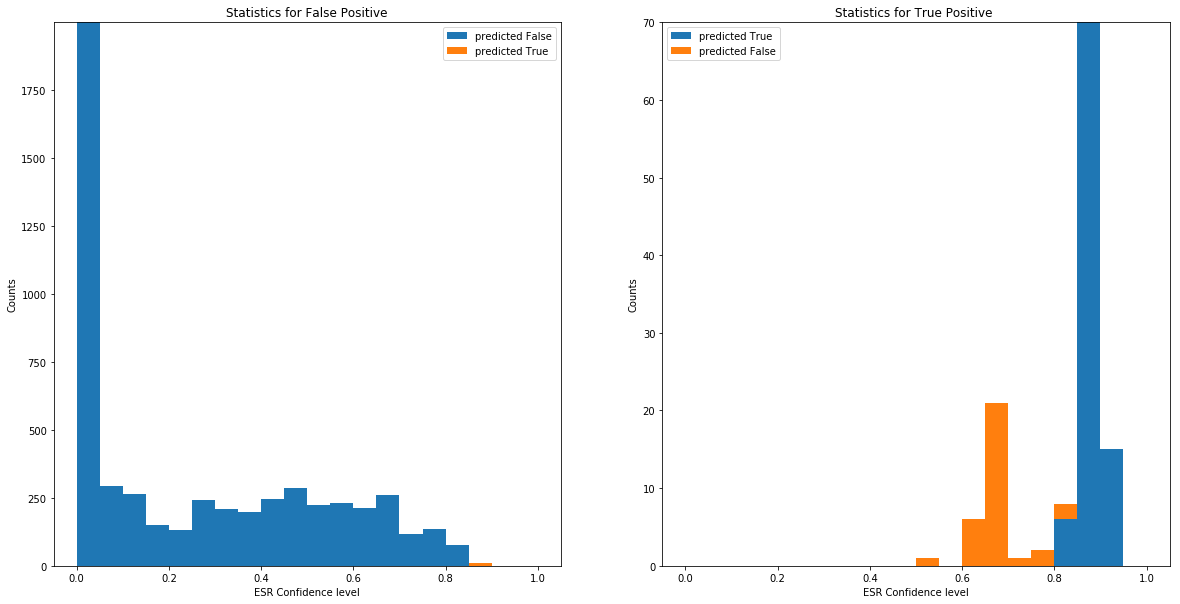

In [90]:
factors=['conf','rangemap','range','y','wid','hgt','time','pred_val']
factor='pred_val'
analyze_factor_panda(results, factor,factors=factors,bins =20,x=[1,10,6,1,20,10,1,1])

 TP  91  FN  33  TN  5264  FP  12
confTrue Positive Recall  [0.00 0.00 0.00 0.00 1.00 1.00 1.00 1.00 0.96 1.00 1.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00]
confFalse Positive Recall  [1.00 0.00 1.00 1.00 1.00 0.99 0.97 0.99 1.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00]


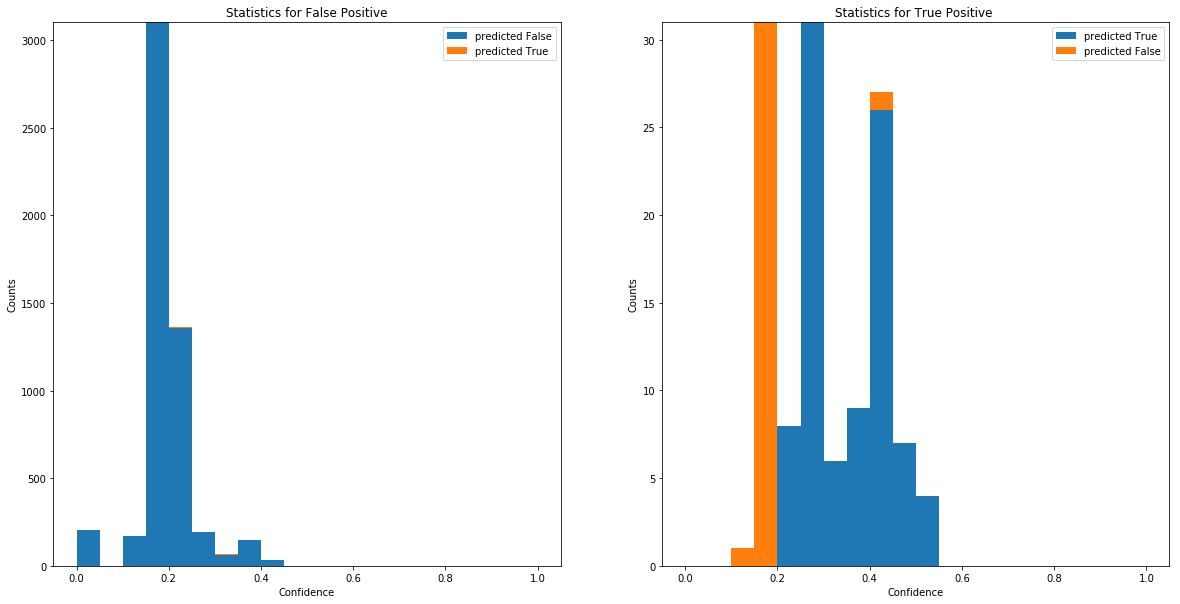

In [91]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='conf'
analyze_factor_panda(results,factor, factor,bins =20, x=[1,10,6,1,20,10,1])

 TP  91  FN  33  TN  5264  FP  12
rangemapTrue Positive Recall  [0.00 0.00 0.00 0.73 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00]
rangemapFalse Positive Recall  [0.00 1.00 1.00 0.99 1.00 1.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
 0.00 0.00 0.00 0.00 0.00 0.00]


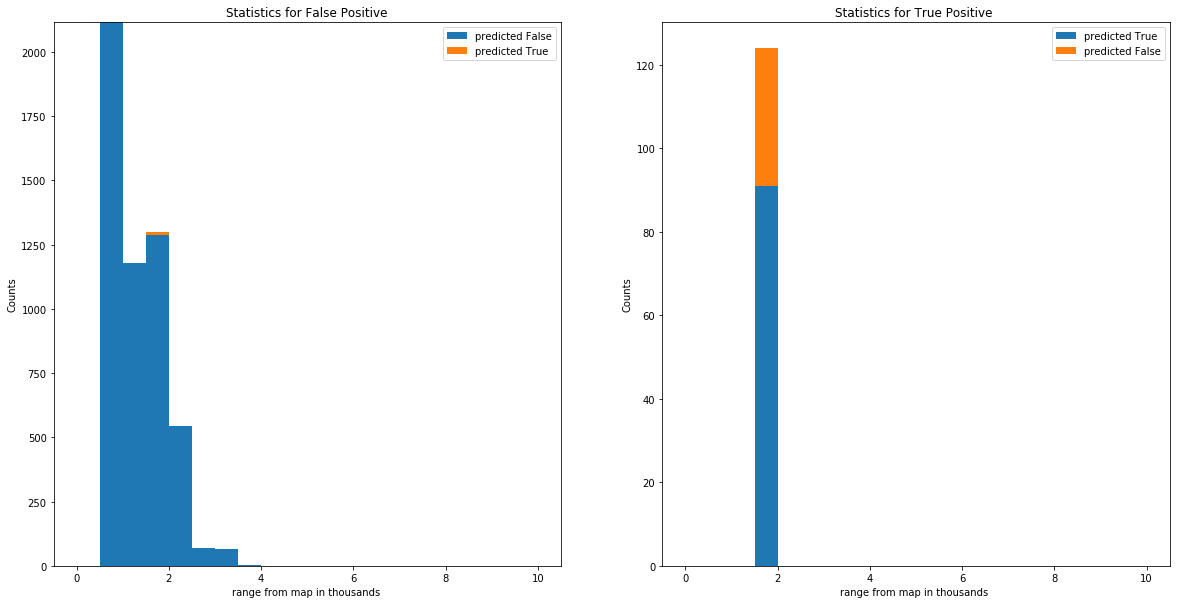

In [92]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='rangemap'
x=[1.5,10,6,1,20,10,1]
analyze_factor_panda(results, factor,x=x, bins=20)

 TP  87  FN  26  TN  5272  FP  15
wid Recall [0.         0.84722222 0.78260869 0.88888888 0.         0.
 0.         0.         0.         0.        ]


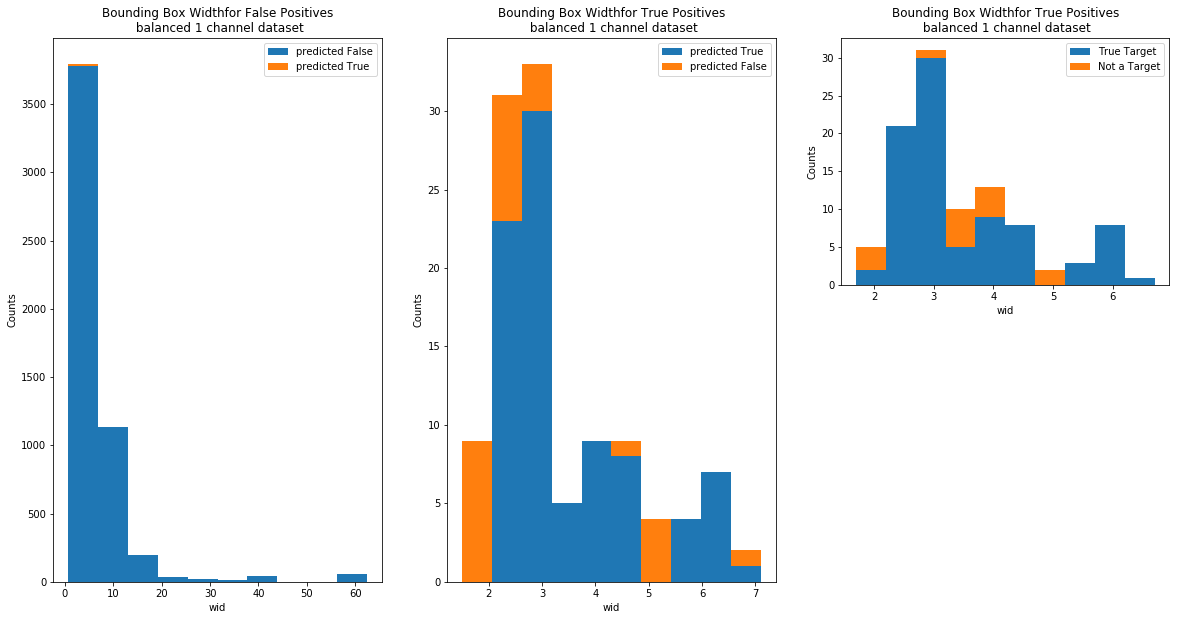

In [103]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='wid'
analyze_factor_panda(results, factor)

 TP  87  FN  26  TN  5272  FP  15
Hgt Recall [0.         0.83333333 0.95652173 0.         0.         0.
 0.         0.         0.         0.        ]


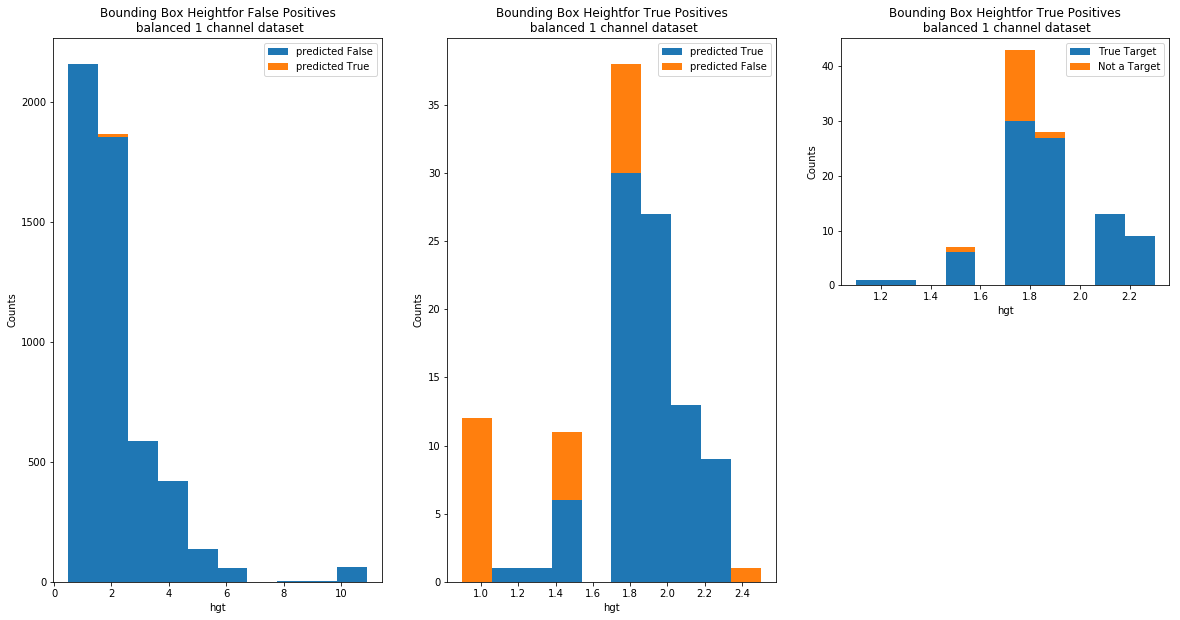

In [104]:
factors=['conf','rangemap','range','y','wid','Hgt','time']
factor='Hgt'
analyze_factor_panda(results,factor,  factors=factors)

 TP  87  FN  26  TN  5272  FP  15
y Recall [0.        0.        0.        0.        0.        0.7699115 0.
 0.        0.        0.       ]


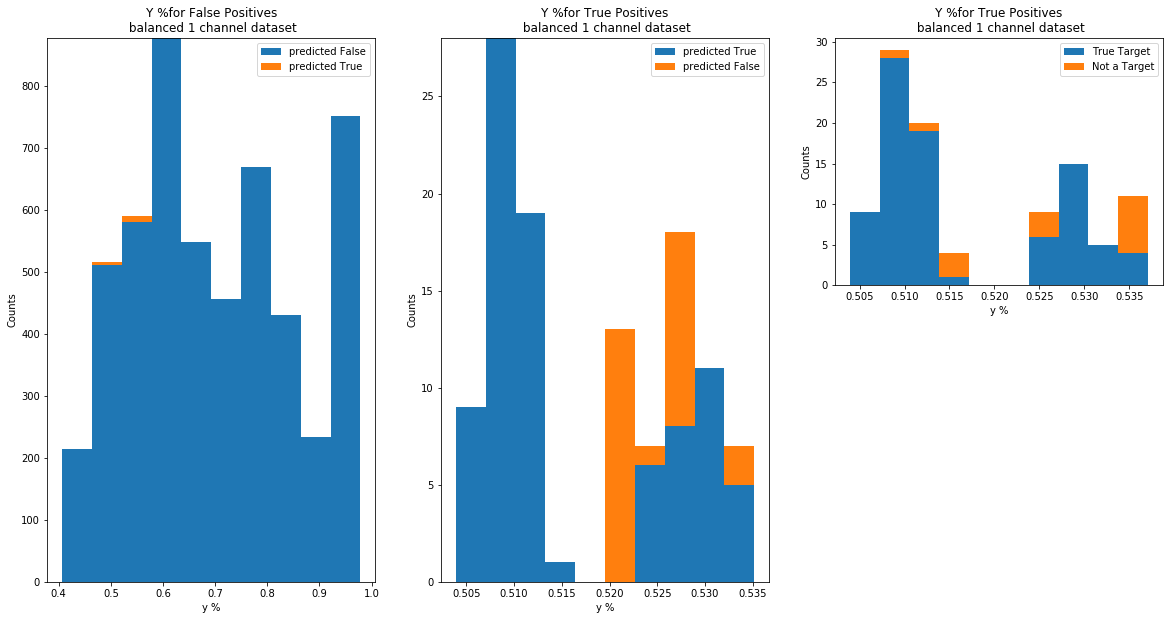

In [105]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='y'
analyze_factor_panda(results,factor, bins=10)

 TP  87  FN  26  TN  5272  FP  15
range Recall [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.7699115]


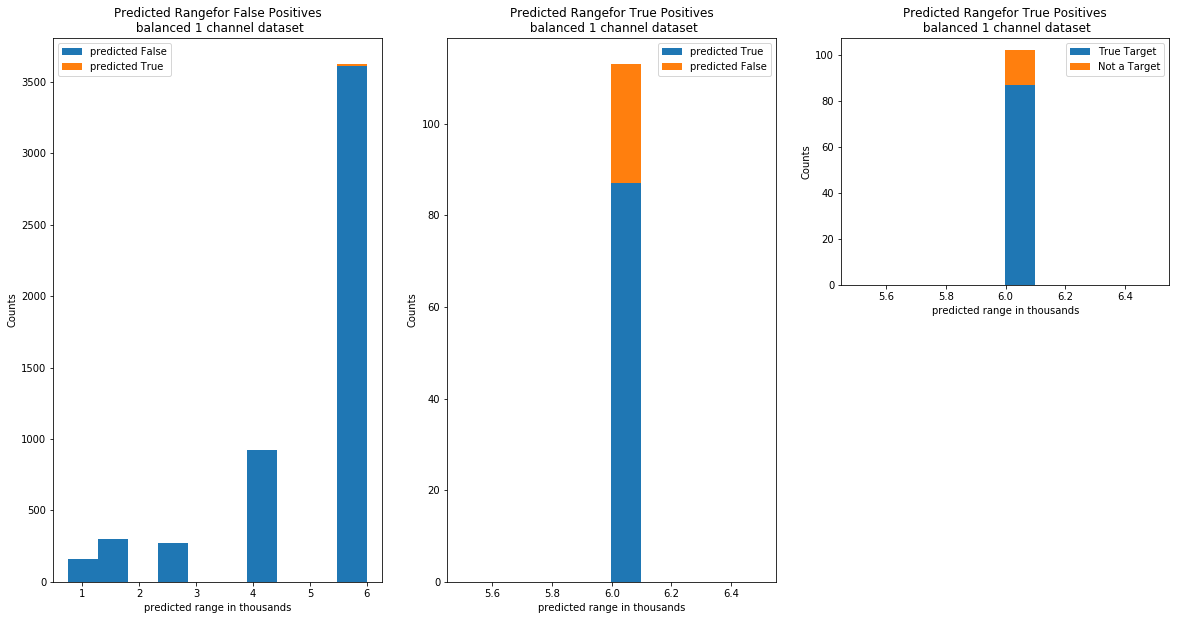

In [106]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='range'
analyze_factor_panda(results,factor,)

In [50]:
def get_avi_dir(name, frmnum, base_dir):
    return base_dir+"multi_frame_captures/"+name+'/'+name+"_frame"+str(frmnum)+'.png'
def get_ARF_dir(name, base_dir):    
    return base_dir+'semantic/'+name+'/'+name+'_000000_ARF.png'

def eval_pred(thresh,pred):
    return 1 if pred>thresh else 0

def test_images_data(data, base_dir,output_directory,long_count=2,thresh=.5):
    make_directory= "test_images/"+output_directory
    !mkdir -p {make_directory}
    data = data[['filename','framenumber','x1','y1','x2','y2',"labels",'conf']]
    print(data.head(3))
    col_dict={"blue":(200,0,0),"green":(0,200,0),'red':(0,0,200),'yellow':(0,200,200)}
    colors=[(200,0,0),(0,200,0),(0,0,200),(0,200,200)]
    image_count=0;    prev_filename=None; prev_frame=None; count=0;
    first=True
    for i,line in data.iterrows():
        #print(type(line))
        if image_count>4:
                break
        if line['filename']!=prev_filename or line['framenumber'] != prev_frame:
            if False:
               cv2.imwrite(make_directory+"/"+str(line['filename'])+"_"+str(line['framenumber'])+".jpg",image) 

            try:
                cv2.imwrite(make_directory+"/"+str(line['filename'])+"_"+str(line['framenumber'])+".jpg",image)
            except:
                pass
            
            image_count+=1
            print('new image',line['filename'], line['framenumber'])
            
            image = cv2.cvtColor(cv2.imread(get_avi_dir(line['filename'], line['framenumber'], base_dir)), cv2.COLOR_BGR2GRAY)
            count=0
        #wid (62.4, 0.7)  Hgt (17.1, 0.5)
        out=[]; #count=1;
        count+=1
        out.append([int(line['labels']),int(line['conf'])*100])
        #box=line['bounding_boxes']
        cv2.putText(image,
                    str(box[0])+', '+str(int(line['labels']))+", "+str(int(line['conf']*100)),
                    (int(box[1]),int(box[2]-4))
                    ,0,0.3,(20,20,20))
        rect_color=select_color(eval_pred(thresh,.52),int(line['labels']),colors)
        
        cv2.rectangle(image,(int(line['x1']),int(line['y1'])),(int(line['x2']),int(line['y2'])),rect_color,2)
        prev_filename =line['filename']
        prev_frame = line['framenumber']
            

def select_color(bpred,label,colors):
    x=[bpred,label]
    if x[1]==0 and x[0]==0:
        return colors[0]
    if x[1]==0 and x[0]==1:
        return colors[1]
    if x[1]==1 and x[0]==1:
        return colors[2]
    if x[1]==1 and x[0]==0:
        return colors[3]


def test_images_df(data, base_dir,output_directory,name,fnumb,thresh=.5):
    make_directory= base_dir+"test_images/"+output_directory
    !mkdir -p {make_directory}
    data = data[['filename','framenumber','x1','y1','x2','y2',"label",'conf','prediction']]
    #print(data.head(3))
    col_dict={"blue":(200,0,0),"green":(0,200,0),'red':(0,0,200),'yellow':(0,200,200)}
    colors=[(200,0,0),(0,200,250),(0,0,250),(0,250,0)]
    #color_lbls=["Tgt:T,Pred:T-RED;"," Tgt:T,Pred:F-YLW;","Tgt:F,Pred:T-GRE;","Tgt:F,Pred:F-BLU"]
    #bounding_box_key="Bounding Box label: Index, True label, POC Conf "

    #image = cv2.cvtColor(cv2.imread(get_avi_dir(name, str(fnumb), base_dir)), cv2.COLOR_BGR2GRAY)
    image = cv2.imread(get_avi_dir(name, str(fnumb), base_dir))
    legend = [['Red True TP',(0,0,200)], ['Blue True FP',(200,0,0)]
              , ['Yellow  False TP',(0,200,200)],["Green False FP ",(0,200,0)]]
    row=20
    for line in legend:
        cv2.putText(image,line[0], (5,row),0,0.5,line[1])
        row+=15
    for i,line in data[(data['filename']==name) & (data['framenumber']==fnumb)].iterrows():
        
        out=[]; #count=1;
        out.append([int(line['label']),int(line['conf'])*100])
        box=line[['x1','y1','x2','y2']].to_numpy()
        cv2.putText(image,
                    str(int(line['conf']*100)),
                    (int(box[0]),int(box[1]-4))
                    ,0,0.3,(20,20,20))
        #rect_color=select_color(eval_pred(thresh,.52),int(line['label']),colors)
        
        cv2.rectangle(image,(int(line['x1']),int(line['y1'])),(int(line['x2']),int(line['y2'])),
                      select_color(line['prediction'],line['label'],colors),2)
    cv2.imwrite(make_directory+'/'+name+"_evalution_.jpg",image)

In [93]:
output_dir='notebooks/frame1'
ok=['avco12221_0001','avco13221_1001','avco13221_1002','avco13221_2001','avco13221_2002','avco13221_3001']
for name in ok:
    test_images_df(results, base_dir,output_dir,name,1,thresh=.80)